# Success of a Kickstarter Campaign: Feature Analysis

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [X] NO - keep private

# Overview

In this project, we conducted data analysis to determine the relationship between funding goal, main category, and location of a Kickstarter campaign and its success. We wanted to determine what factors of a campaign relate to a higher chance of its success. 

We found that campaigns with lower goal amounts (US$) had much a higher proportion of money pledged and therefore a higher success rate. Campaigns with high goal amounts had proportion pledged almost equal zero. On the other hand, we found no significant relationship between country and success rate or between main category and success rate.


# Names

- Seokhyun Ryu
- Jieun Lee
- Gauri Samith
- Aditi Krishnakumar

<a id='research_question'></a>
# Research Question

What is the relationship between funding goal, main category, and location of a Kickstarter campaign and its success?

<a id='background'></a>

## Background & Prior Work

- *__An Introduction to the platform:__*
Kickstarter is an American public benefit corporation based in Brooklyn, New York, it maintains a global crowdfunding platform focused on creativity. The company's stated mission is to "help bring creative projects to life".As of December 2019, Kickstarter has received more than $4.6 billion in pledges from 17.2 million backers to fund 445,000 projects, such as films, music, stage shows, comics, journalism, video games, technology, publishing, and food-related projects.

- *__How it works:__*
Every project creator sets their project's funding goal and deadline. If people like the project, they can pledge money to make it happen. If the project succeeds in reaching its funding goal, all backers' credit cards are charged when time expires. Funding on Kickstarter is all-or-nothing. If the project falls short of its funding goal, no one is charged. 

The main question that pops up is _"What exactly makes a project that successful?"_ We believe that there is a possibility that successful projects do possess some common features. Thus, we plan to look into the data available from past Kickstarter projects - whether fails or successes - and see why the outcome was so.

While our preliminary dataset search involved Google, our main source of datasets were portals such as Kaggle that specialize in Data Science projects. We came across the **"Kickstarter Projects"** and the **"Kickstarter Project Statistics"** datasets that fulfilled our requirements. Links to both of these are available below.

**Kickstarter Projects:** There are two available files here from both December 2016 as well as January 2018. Each of these files are composed of around 300,000 to 400,000 unique projects. 

**Kickstarter Project Statistics:** Once again, there are two files available. This time, one of them gives us 4000 projects that were live at that point in time, and the other covers 4000 of the most backed projects at the time. 

Upon further inspection, we narrowed down to the **"Kickstarter Projects"** dataset as it was larger in size. We concur that it could likely lead to a more accurate analysis.

We decided to analyze the dataset of 2018, considered the number of projects and the recent year of the dataset. 

References (include links):
- 1)__https://www.kickstarter.com/help/taxes__ (How it works)
- 2)__https://en.wikipedia.org/wiki/Kickstarter__ (Introduction)
- 3)__https://www.kaggle.com/socathie/kickstarter-project-statistics__ (Kickstarter Project Statistics Dataset)

# Hypothesis


We hypothesize that the main category, funding goal, and location of a Kickstarter campaign will determine the success of a campaign. We predict that a lower funding goal will lead to a higher chance of success and that campaigns located in western countries in the category of Technology will have a higher chance of success.

# Dataset(s)


- Dataset Name: ks-projects-201801.csv
- Link to the dataset: https://www.kaggle.com/kemical/kickstarter-projects
- Number of observations: 378660

Kickstarter Project Dataset "ks-projects-201801.csv" has 378660 observations and 16 features. This dataset contains data on a number of factors that contribute to the success or failure of the project. After, We analyzed 16 features and add new features such as ‘duration’ by computing the duration between launched date and the deadline and remove unnecessary columns. 



# Setup

In [1]:
import pandas as pd
import datetime
import numpy as np
import random

import seaborn as sns
sns.set_palette('pastel')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = '20'

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, chisquare, normaltest
from scipy.stats import f_oneway
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso

%config InlineBackend.figure_format ='retina'

# Data Cleaning

In [2]:
ks_projects = pd.read_csv("ks-projects-201801.csv")
ks_projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
# helper method to convert launched variable from str to datetime
def convert_launched(date_time):
    date = date_time[:10]
    date_time_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    return date_time_obj

def convert_deadline(date):
    date_time_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    return date_time_obj

# helper method to create duration column
def duration():
    differences = []
    for i in range(ks_projects.shape[0]):
        difference = (ks_projects.get("deadline")[i] - ks_projects.get("launched")[i]).days
        differences.append(difference)
    return differences

ks_projects = ks_projects.assign(launched = ks_projects.get("launched").apply(convert_launched))
ks_projects = ks_projects.assign(deadline = ks_projects.get("deadline").apply(convert_deadline))
ks_projects = ks_projects.assign(duration = duration())
ks_projects.head()


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,45
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,30
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,1283.0,1283.0,19500.00,56


checking the number of values in the column of `state` and `country`


In [4]:
print(ks_projects.get("state").value_counts(),"\n")
print(ks_projects.get("country").value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64 

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64


In [5]:
ks_n0 = ks_projects[ks_projects.get("country") == "N,0\""]
print(ks_projects['state'].value_counts())
ks_n0.head()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06,555.00,undefined,0,"N,0""",NaN,555.00,6500.00,45
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53,21
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00,30
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00,24
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00,27


__We checked the Kickstarter website itself to determine whether observations country 'N,0"' were all from a specific country type. We discovered that there were no common features between countries that were marked as 'N,0"' in the dataset and this is simply likely due to an error while webscraping.__

__Since location is one of our variables of interest and N,0 is not from a specific category of observations but spread throughout randomly, we decided it would be better to drop rows with country as 'N,0"'__

In [6]:
ks_projects = ks_projects[ks_projects.get("country") != "N,0\""]
ks_projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,45
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,30
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,1283.0,1283.0,19500.00,56


__According to the information on Kaggle, the `pledged` column contains the amount of money pledged in the currency of the campaign's location. `usd_pledged` is the amount pledged converted to USD by the Kickstarter platform itself and `usd_pledged_real` is the pledged amount converted to USD using https://fixer.io/. We wanted to clarify the difference between the two and choose which would be better to use. The `usd_goal_real` column also has conversions from https://fixer.io/.__

In [7]:
# checking 'usd pledged' and 'usd_pledged_real' for campaigns with USD currency
ks_projects_usd = ks_projects[ks_projects.get("currency") == "USD"]
ks_projects_usd = ks_projects_usd.assign(difference_usd_pledged_real = abs(ks_projects_usd.get("usd_pledged_real") - ks_projects_usd.get("pledged")))
ks_projects_usd = ks_projects_usd.assign(difference_usd_pledged = abs(ks_projects_usd.get("usd pledged") - ks_projects_usd.get("pledged")))
ks_projects_usd.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,duration,difference_usd_pledged_real,difference_usd_pledged
count,2.926270e+05,2.926270e+05,2.926270e+05,292627.000000,2.926270e+05,2.926270e+05,2.926270e+05,292627.000000,292627.0,2.926270e+05
mean,1.075281e+09,4.403497e+04,9.670193e+03,113.078615,7.677881e+03,9.670193e+03,4.403497e+04,34.740930,0.0,1.994244e+03
std,6.191924e+08,1.108372e+06,9.932942e+04,985.723400,8.641007e+04,9.932942e+04,1.108372e+06,68.025057,0.0,4.015676e+04
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,1.000000,0.0,0.000000e+00
25%,5.389118e+08,2.000000e+03,4.100000e+01,2.000000,2.500000e+01,4.100000e+01,2.000000e+03,30.000000,0.0,0.000000e+00
50%,1.076050e+09,5.250000e+03,7.250000e+02,14.000000,5.100000e+02,7.250000e+02,5.250000e+03,30.000000,0.0,0.000000e+00
75%,1.611294e+09,1.500000e+04,4.370000e+03,60.000000,3.424000e+03,4.370000e+03,1.500000e+04,38.000000,0.0,0.000000e+00
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.000000e+08,14867.000000,0.0,7.164658e+06


__We created two columns to determine the difference between pledged amount and the usd converted amount for both `usd_pledged` and `usd_pledged_real` respectively. We then extracted the data for the projects which had their `pledged` amount in USD originally. This would mean that the converted amount should be equal to the original pledged amount as both currencies are in USD.__

__The differences between `usd_pledged_real` and `pledged` for columns with currency USD is 0. Whereas, the differences between `usd_pledged` and `pledged` ≠ 0. This proves that the conversion in the `usd_pledged_real` is accurate and a better option to use in the analysis. We decided to drop the `usd_pledged` column.__

In [8]:
ks_projects = ks_projects.drop(columns = ["usd pledged"])
ks_projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,1283.0,19500.00,56


# Data Analysis & Results

## Exploratory Data Analysis

We will look at the descriptive statistics to have general understanding of our datasets. 

In [9]:
ks_projects.describe()

,ID,goal,pledged,backers,usd_pledged_real,usd_goal_real,duration
count,3.748640e+05,3.748640e+05,3.748640e+05,374864.000000,3.748640e+05,3.748640e+05,374864.000000
mean,1.074651e+09,4.952310e+04,9.750436e+03,106.687276,9.120803e+03,4.586318e+04,34.497676
std,6.191357e+08,1.189355e+06,9.601043e+04,911.705321,9.131921e+04,1.158761e+06,66.231804
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,1.000000
25%,5.380708e+08,2.000000e+03,3.100000e+01,2.000000,3.100000e+01,2.000000e+03,30.000000
50%,1.075277e+09,5.500000e+03,6.200000e+02,12.000000,6.244100e+02,5.500000e+03,30.000000
75%,1.610137e+09,1.650000e+04,4.080000e+03,57.000000,4.050815e+03,1.600000e+04,37.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,16739.000000


In [10]:
print("Number of observations: ", ks_projects.shape[0])
print("Number of features: ", ks_projects.shape[1])
print("Number of states:", len(ks_projects.state.unique()))
print("Number of project categories:", len(ks_projects.main_category.unique()))
print("Number of countries:", len(ks_projects.country.unique()))

Number of observations:  374864
Number of features:  15
Number of states: 5
Number of project categories: 15
Number of countries: 22


### Country Focused Visualizations

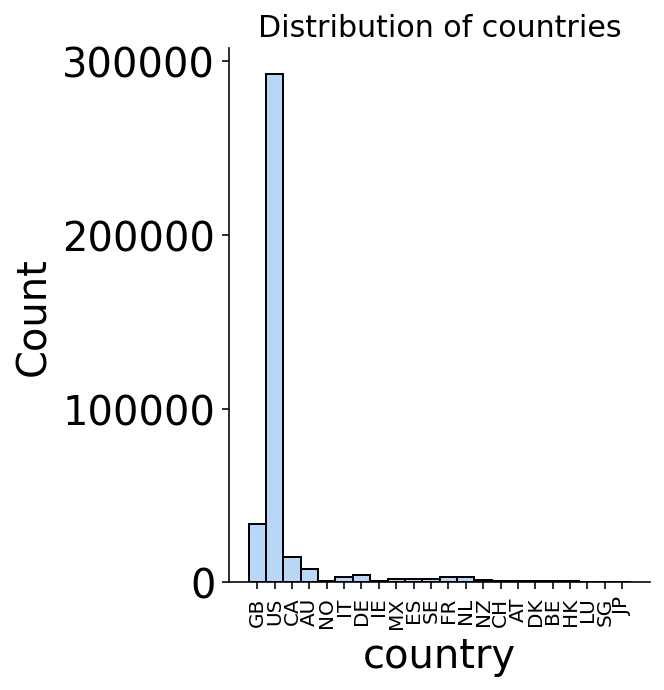

In [11]:
# distribution of locations
sns.displot(ks_projects['country'])
plt.xticks(rotation = 90, fontsize = 10)
plt.title('Distribution of countries', fontsize = 15)
plt.show()

- As we can see the distribution and descriptive information, the majority of the Kickstarter campaigns are from the United States.

Text(0, 0.5, 'usd_pledged_real')

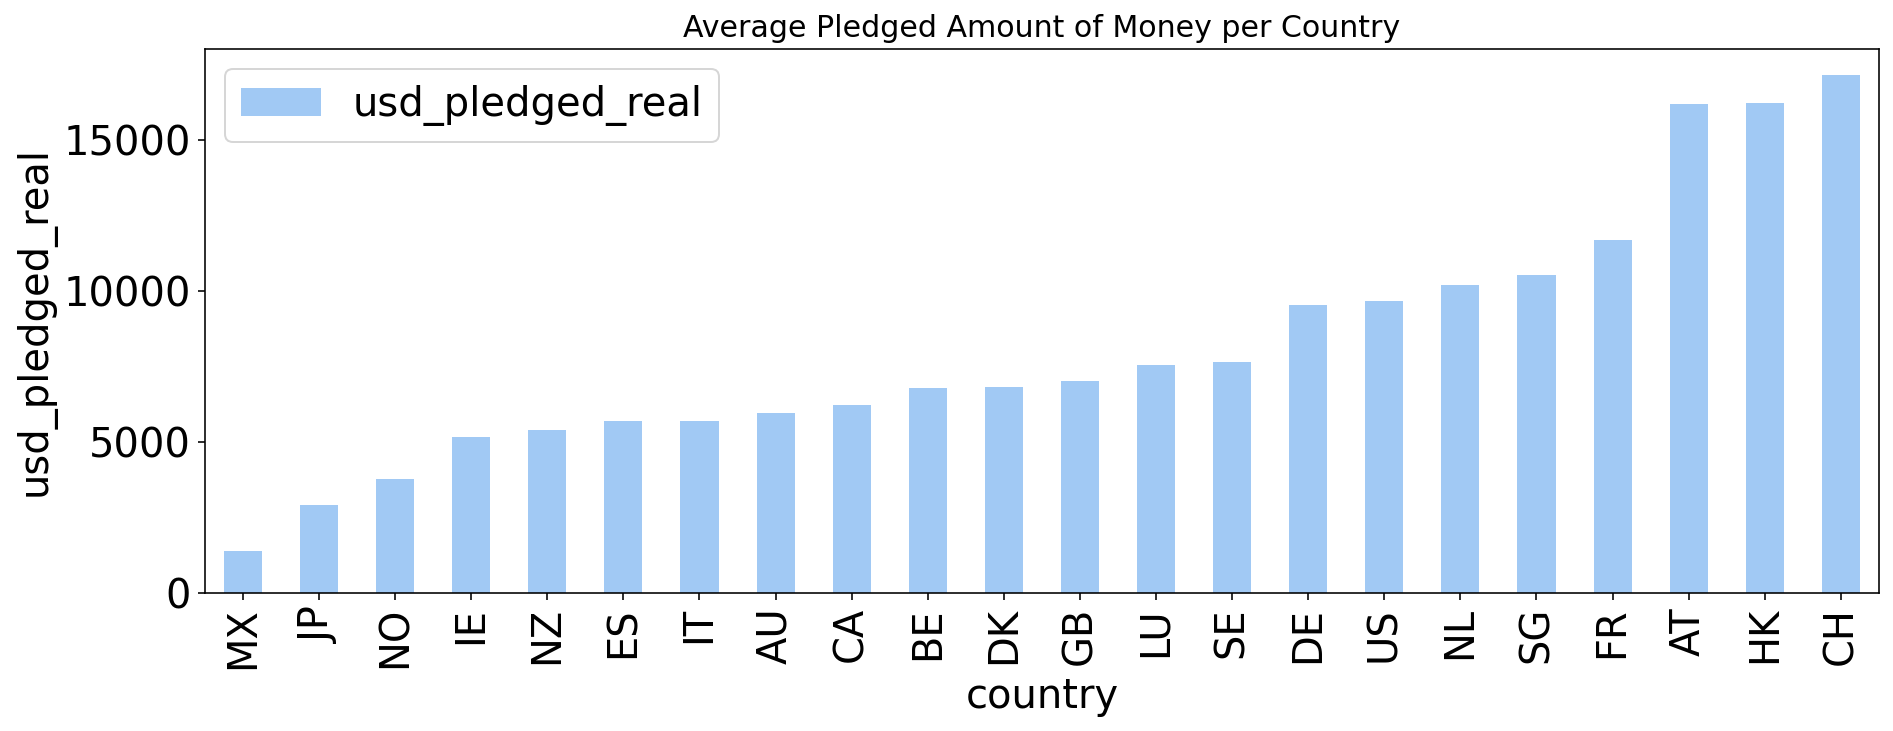

In [12]:
ks_projects.groupby("country").mean().sort_values(by = "usd_pledged_real").plot(y = 'usd_pledged_real', kind = 'bar')
plt.title('Average Pledged Amount of Money per Country', fontsize = 15)                                 
plt.ylabel('usd_pledged_real')

- We sorted 22 countries based on pledged usd, We noticed China has the highest average pledged amount

Text(0.5, 1.0, 'Average Proportion Pledged per Country')

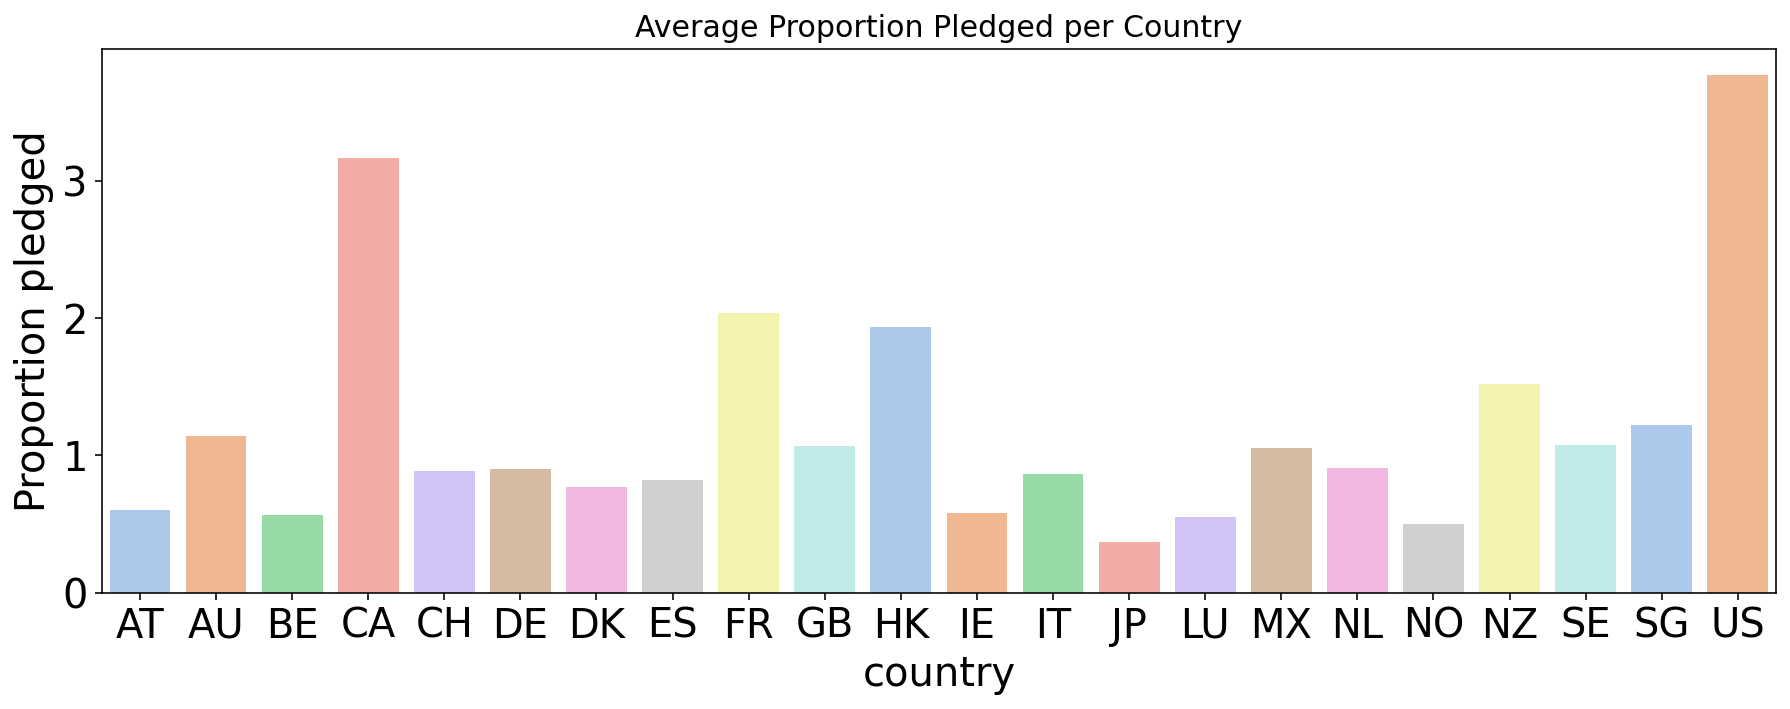

In [13]:
# adding a column on proportion pledged to goal amount
pledged_prop = ks_projects.get('usd_pledged_real')/ks_projects.get('usd_goal_real')
ks_projects = ks_projects.assign(pledged_prop = pledged_prop)
ks_country = ks_projects.groupby('country').mean().reset_index()
sns.barplot(x = 'country', y = 'pledged_prop', data = ks_country, palette = 'pastel')
plt.ylabel('Proportion pledged')
plt.title('Average Proportion Pledged per Country', fontsize = 15)

- US has the highest average proportion pledged compared to goal amount
- Japan has the lowest average proportion pledged compared to goal amount

We decided to Focusing on 'successful' and 'failed' states since rest of the states are ambiguous on the criteria of success and failure

In [14]:
# only including failed and successful states
ks_state = ks_projects[ks_projects['state'].isin(['failed', 'successful'])]


<AxesSubplot:title={'center':'Average Proportion of Success per Country'}, xlabel='Country', ylabel='Proportion of Success'>

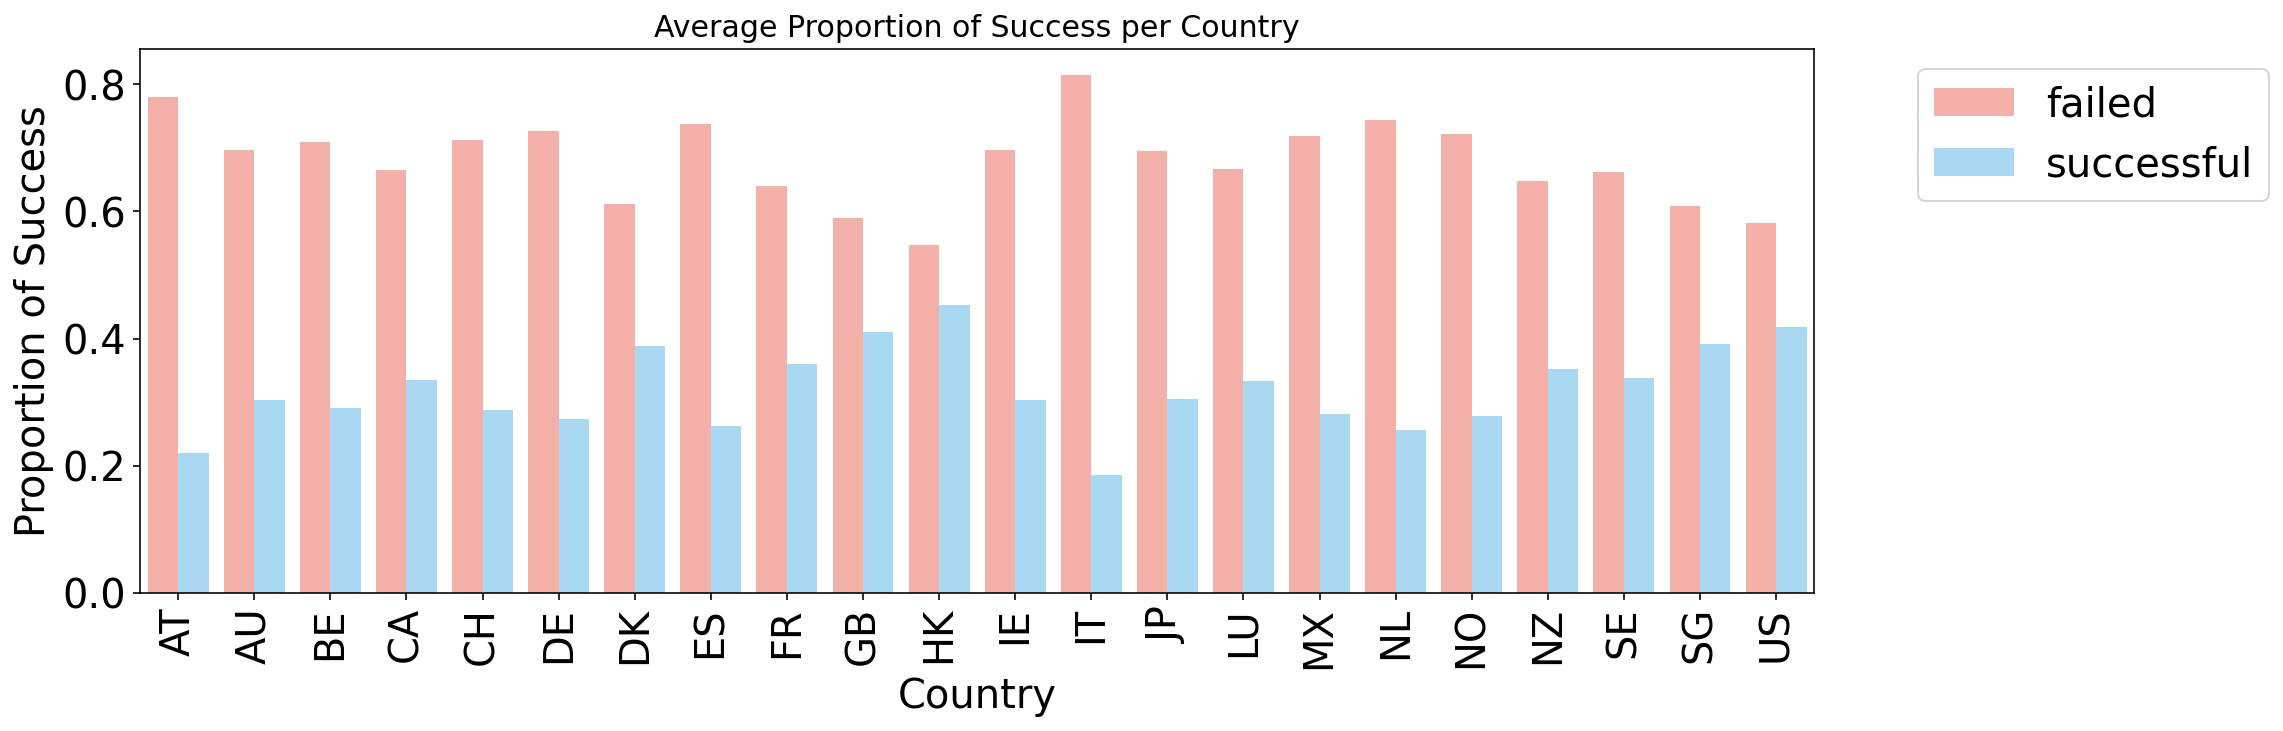

In [15]:
# proportion of success based on location
prop_loc = (ks_state.groupby('country')['state']
              .value_counts(normalize = True)
              .rename('proportion')
              .reset_index())
ax = sns.barplot(x = 'country', y = 'proportion', hue = 'state', data = prop_loc,palette = ['#FFA69D' ,'#9DDBFF'] )
plt.xticks(rotation = 90)
plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.ylabel('Proportion of Success')
plt.xlabel('Country')
plt.title('Average Proportion of Success per Country', fontsize = 15)
ax

- Hong Kong has highest proportion of successful campaigns
- Italy has highest proportion of failed campaigns

### Main Category Focused Visualizations

In [16]:
ks_projects.groupby('main_category').mean()

,ID,goal,pledged,backers,usd_pledged_real,usd_goal_real,duration,pledged_prop
main_category,,,,,,,,
Art,1.077788e+09,40829.180144,3606.970044,42.205094,3220.986968,39198.575879,33.136327,2.492288
Comics,1.063611e+09,20243.646297,6899.311189,134.771236,6610.443828,19571.430669,34.156854,6.433868
Crafts,1.078527e+09,11592.285901,2016.153947,27.283687,1632.907282,10434.466228,31.590078,2.440751
Dance,1.075283e+09,10313.452694,3691.725362,42.812583,3453.809894,9580.255368,33.103000,0.807409
Design,1.078305e+09,46735.798780,27122.057304,241.323710,24419.015795,41872.967088,34.982206,2.080765
Fashion,1.069726e+09,24817.556586,6549.594221,61.458574,5712.865119,22411.101040,32.855865,1.004039
Film & Video,1.074594e+09,85466.069456,6425.942053,66.950205,6218.099883,83736.685954,35.806929,1.525282
Food,1.081877e+09,48697.082467,5340.804411,54.179072,5114.282154,49042.826715,34.077523,0.838949
Games,1.072090e+09,50714.432981,21866.825657,321.831289,21043.346236,44925.955347,32.553313,7.465416


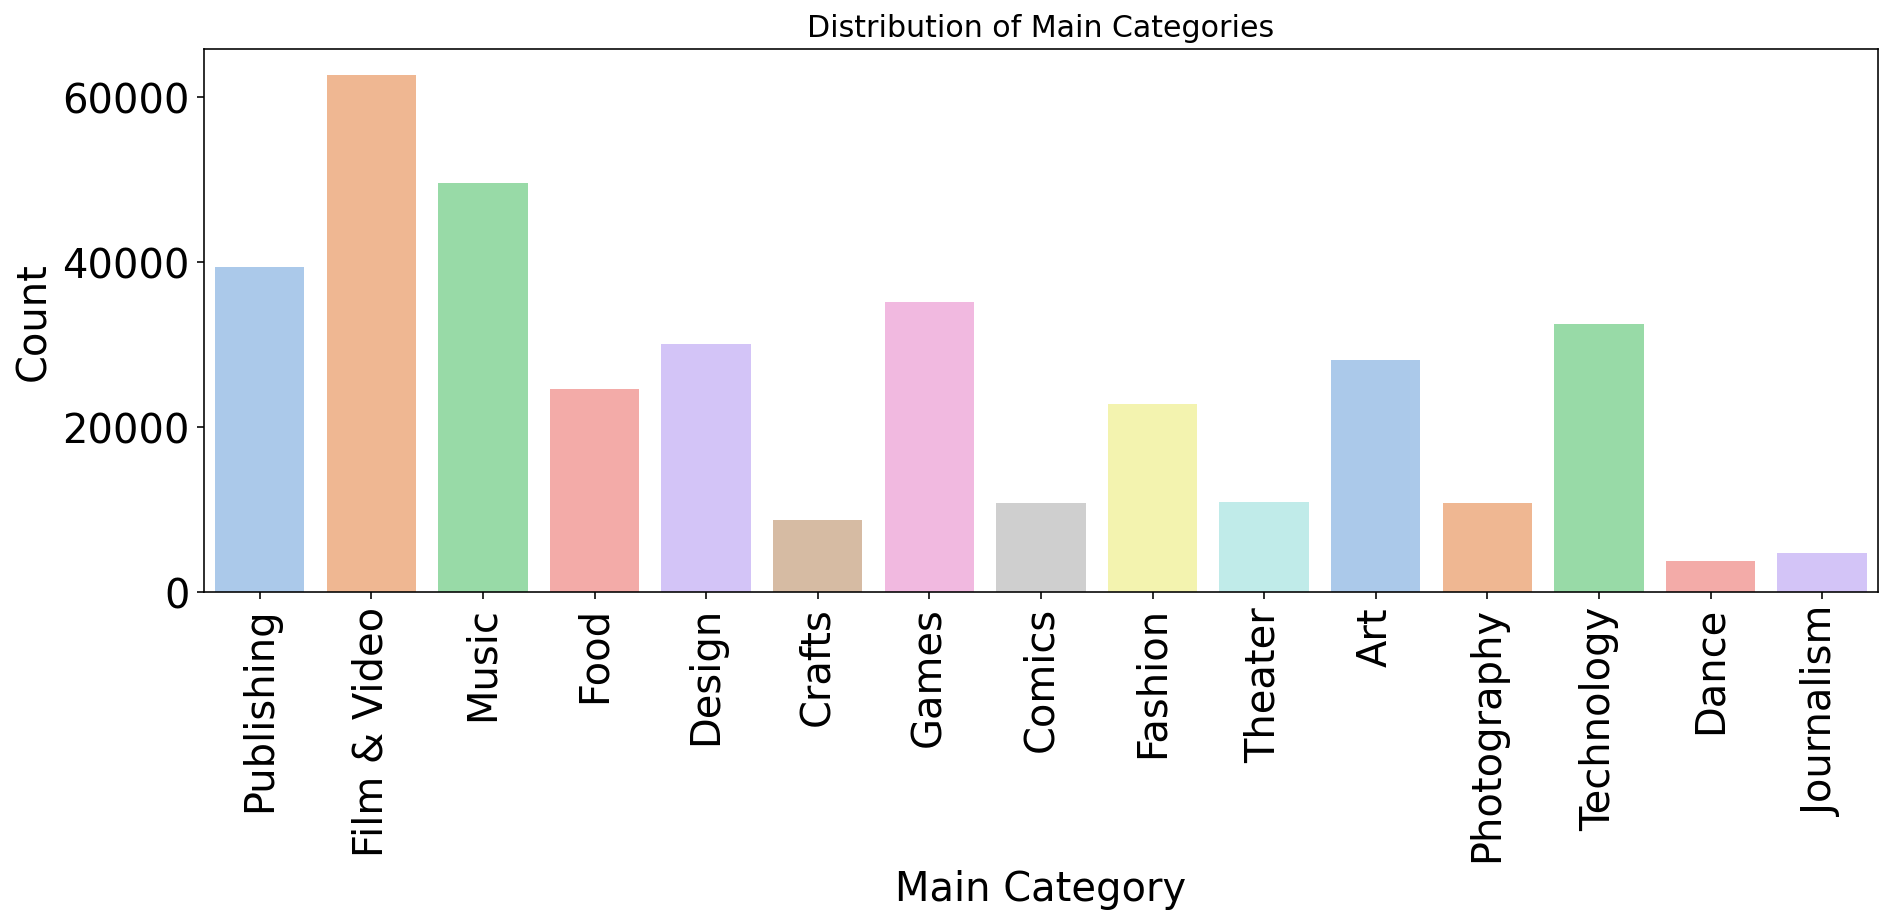

In [17]:
# main categories
ax = sns.countplot(x= 'main_category', data=ks_projects, palette = 'pastel')
plt.xticks(rotation=90)
plt.xlabel('Main Category')
plt.ylabel('Count')
plt.title('Distribution of Main Categories', fontsize = 15)
plt.show()

- Countplot shows 'Film & Video' category is the most dominat category of Kickstarter projects, whereas 'Dance' is the least.

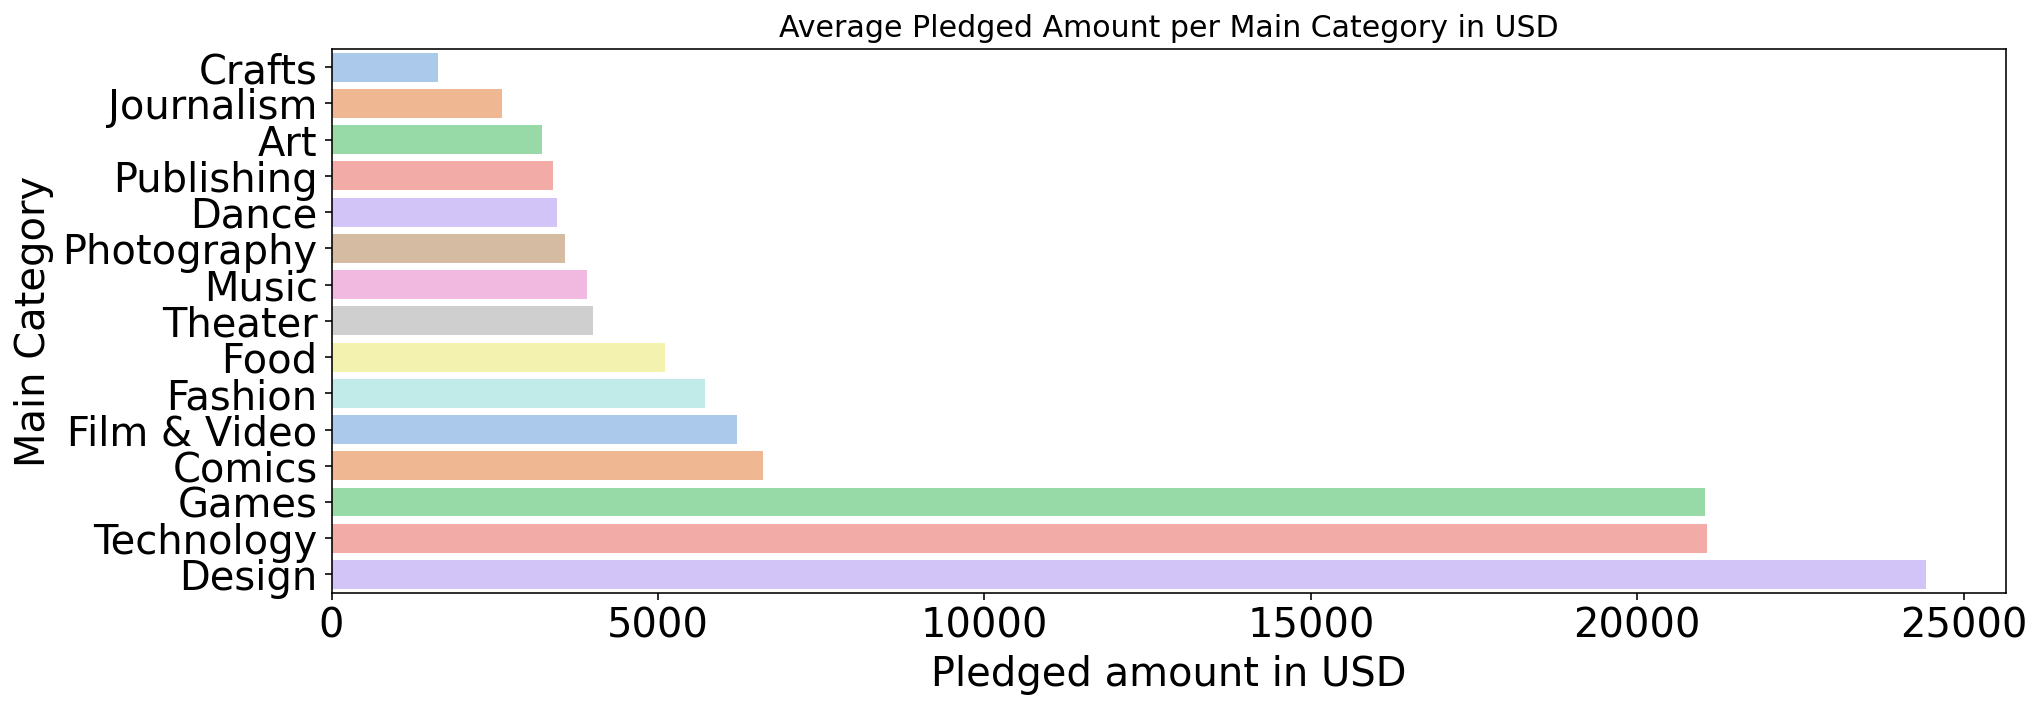

In [18]:
ks_category = ks_projects.groupby('main_category').mean().sort_values(by = 'usd_pledged_real') # Done
ks_category = ks_category.reset_index()
sns.barplot(x = 'usd_pledged_real', y = 'main_category', data = ks_category, palette = 'pastel')
plt.ylabel('Main Category')
plt.xlabel('Pledged amount in USD')
plt.title('Average Pledged Amount per Main Category in USD', fontsize = 15)
plt.show()

- Design, Tech, and Games have the highest pledged amount on average and Dance has the least

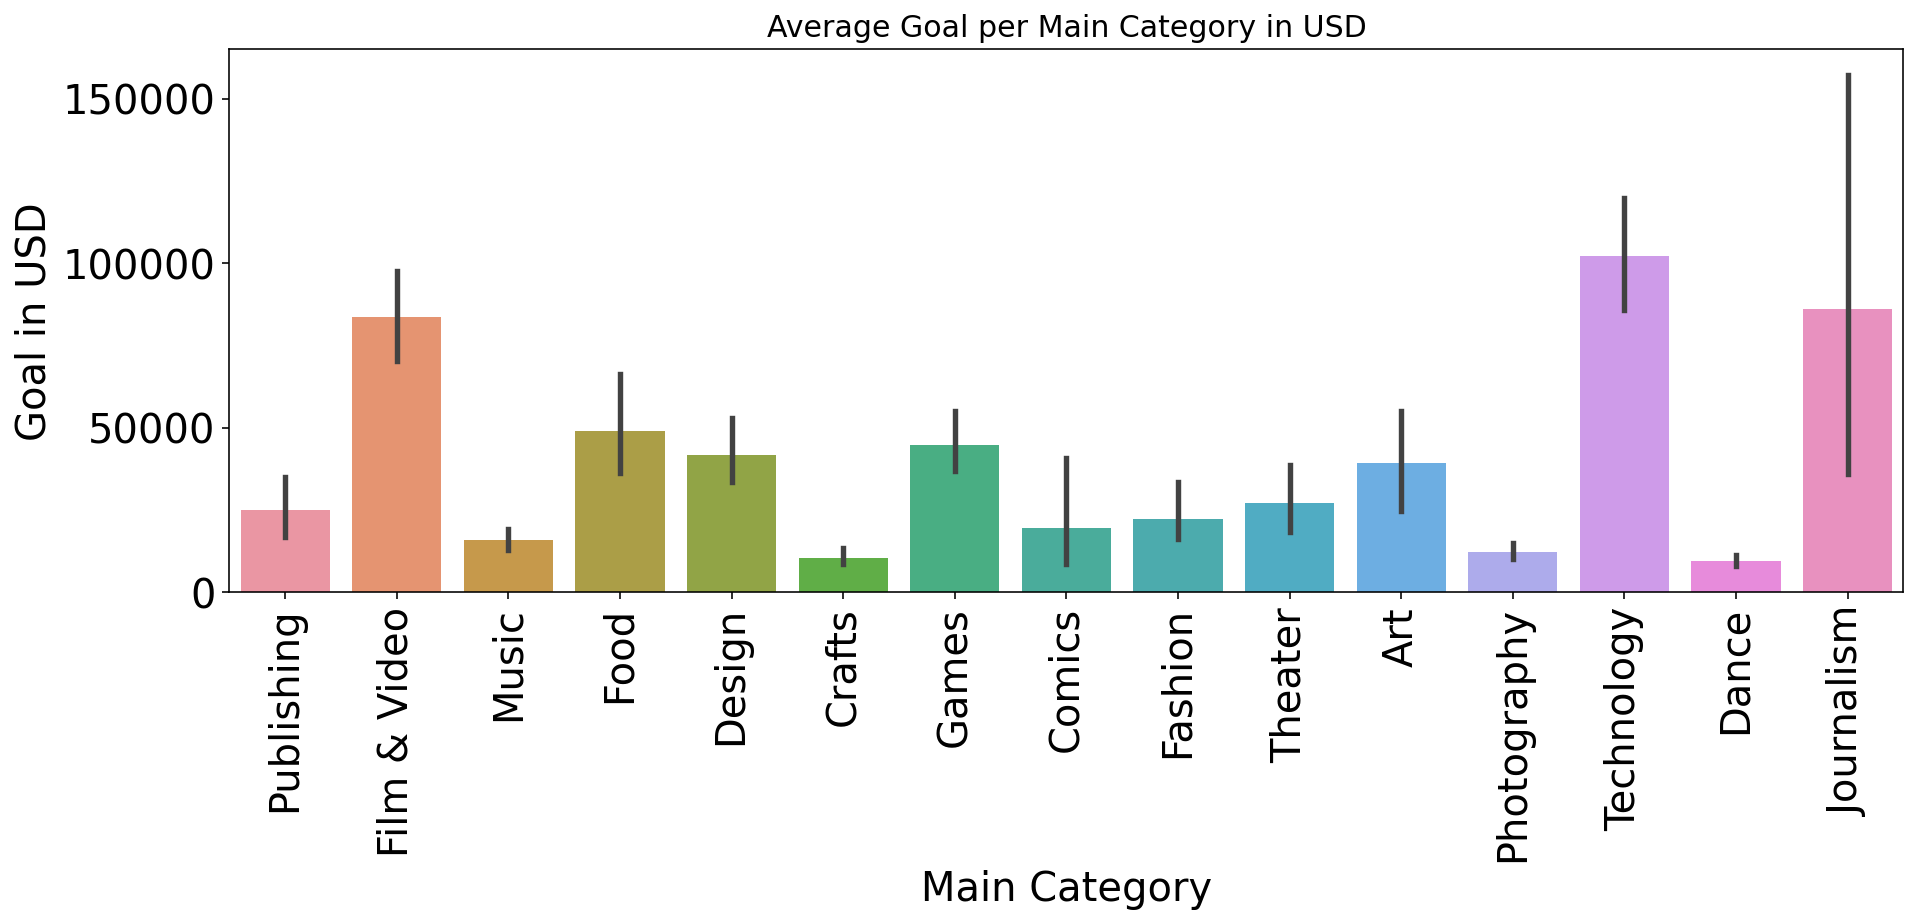

In [19]:
# barplot with main category and goal
ax = sns.barplot(x = 'main_category', y = 'usd_goal_real', data = ks_projects)
plt.xticks(rotation = 90)
plt.xlabel('Main Category')
plt.ylabel('Goal in USD')
plt.title('Average Goal per Main Category in USD', fontsize = 15)
plt.show()

 - Technology has the highest average goal amount overall while dance has the least

Text(0.5, 1.0, 'Average Proportion of Success per Main Category')

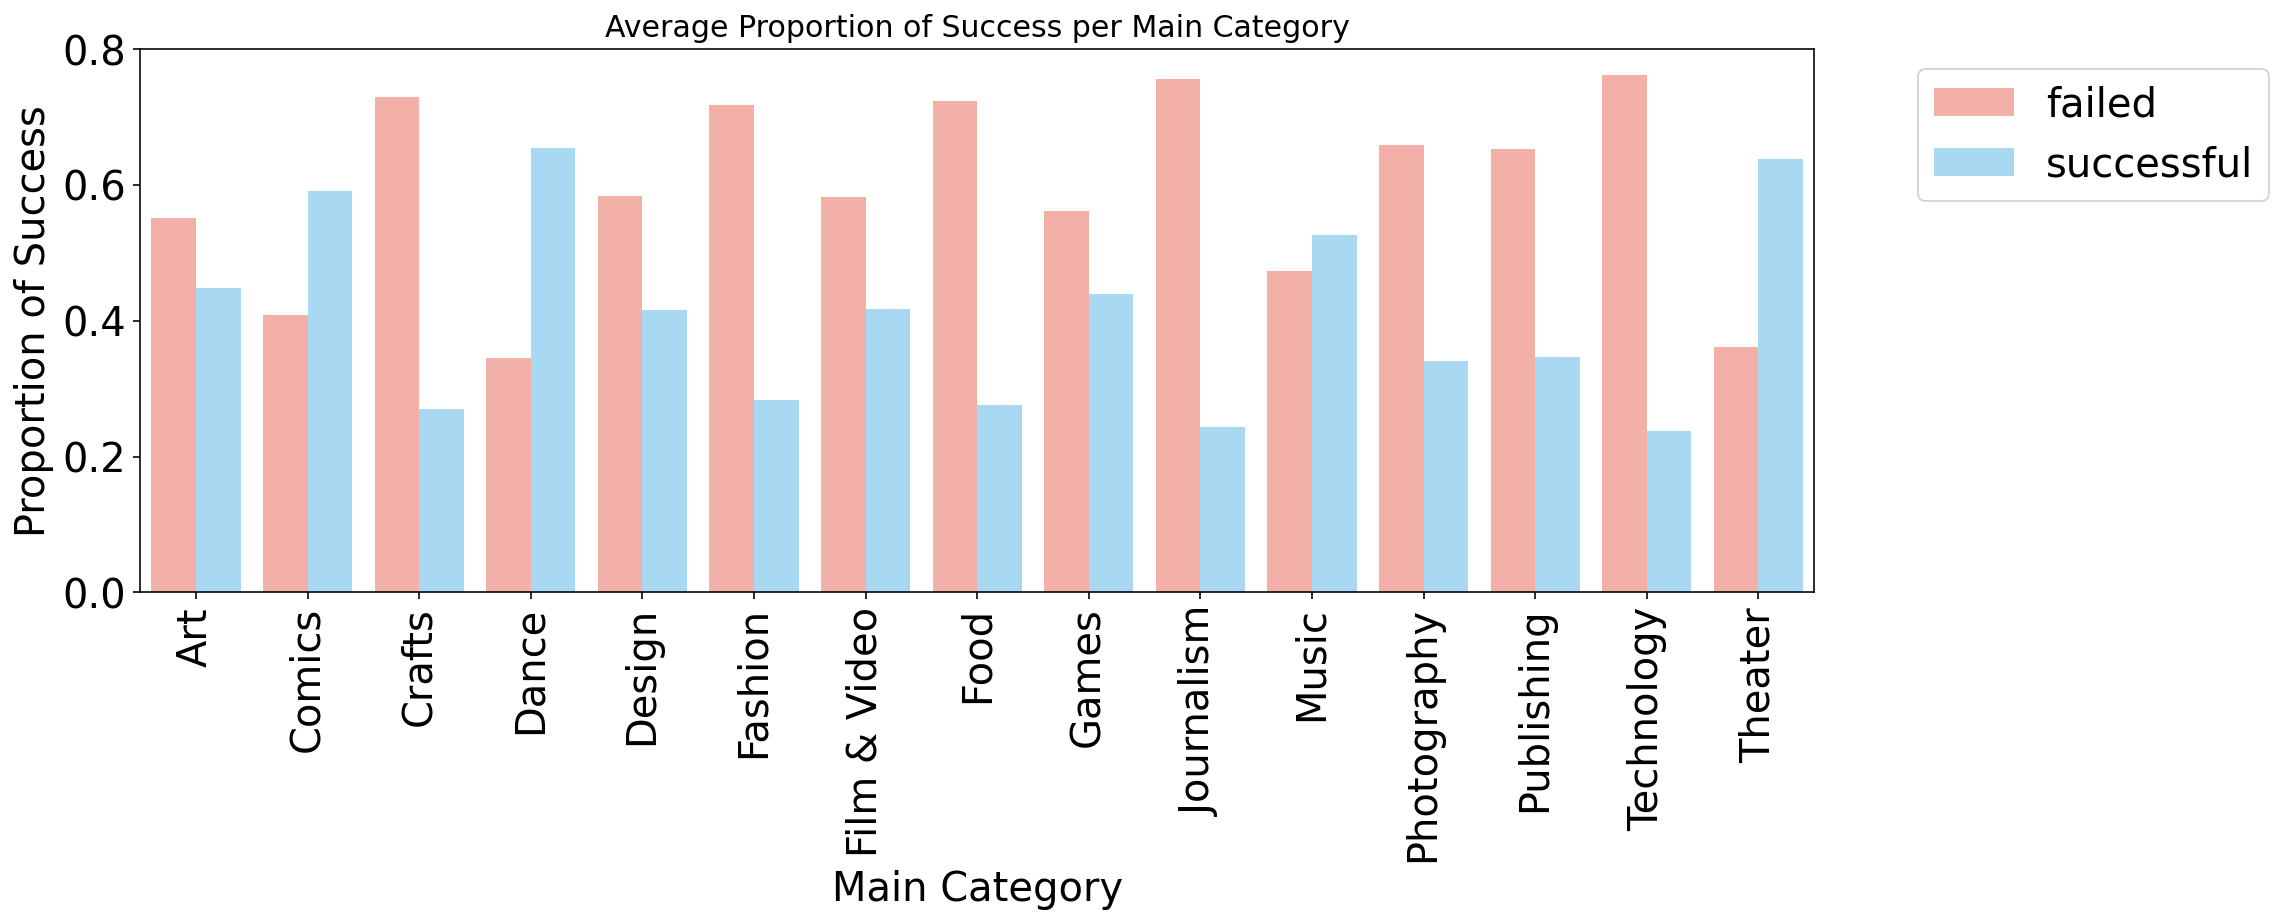

In [20]:
# check proportion of success of each category
prop_state = (ks_state.groupby('main_category')['state']
              .value_counts(normalize = True)
              .rename('proportion')
              .reset_index())
ax = sns.barplot(x = 'main_category', y = 'proportion', hue = 'state', data = prop_state, palette = ['#FFA69D' ,'#9DDBFF'] )
plt.xticks(rotation = 90)
plt.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))
plt.ylabel('Proportion of Success')
plt.xlabel('Main Category')
plt.title('Average Proportion of Success per Main Category', fontsize = 15)



- Technology has highest proportion failed. 
- Dance has highest proportion success

In [21]:
# creating a column on differences between pledged and goal amounts
ks_projects = ks_projects.assign(difference = ks_projects.get('usd_pledged_real') - ks_projects.get('usd_goal_real'))
ks_projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop,difference
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59,0.000000,-1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60,0.080700,-27579.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45,0.004889,-44780.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30,0.000200,-4999.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,1283.0,19500.00,56,0.065795,-18217.00


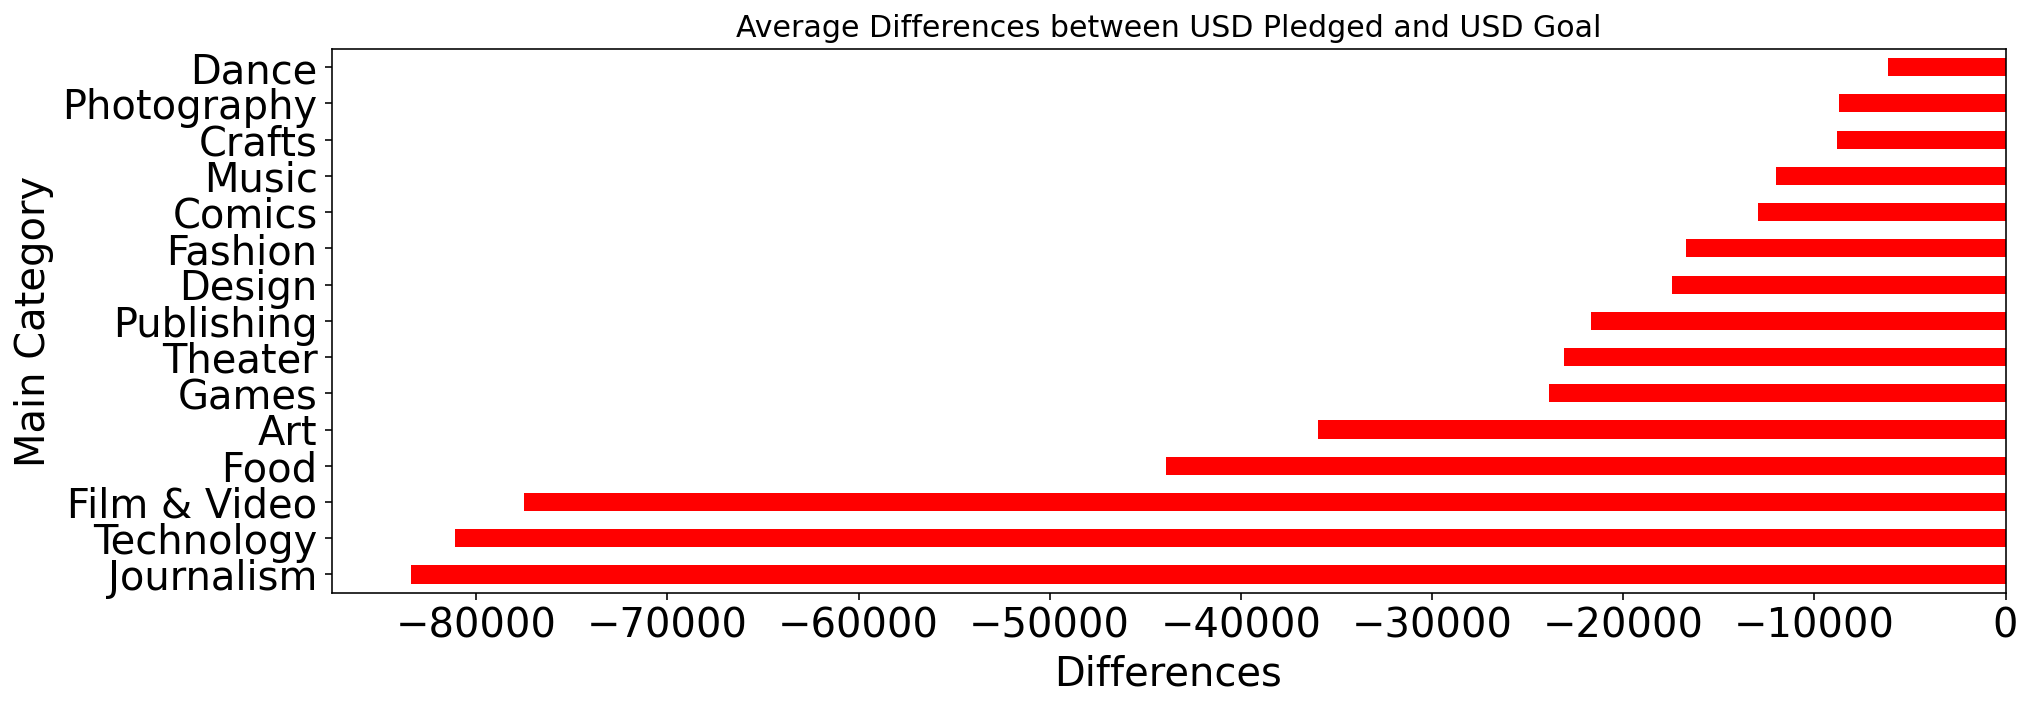

In [22]:
ks_differences = ks_projects.groupby('main_category').mean().sort_values(by = 'difference')
ks_differences['difference'].plot(kind='barh',
                    color=(ks_differences['difference'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.title('Average Differences between USD Pledged and USD Goal', fontsize = 15)
plt.xlabel('Differences')
plt.ylabel('Main Category')
plt.show()

- This shows us that, on average, the difference between pledged and goal amount is negative. However, this could be skewed by outliers so we created a subset of the goal amount with values below 100,000

In [23]:
# removing outliers from goal amount
goal_subset = ks_projects[ks_projects.get('usd_goal_real') <= 100000]
print(goal_subset.shape)
goal_subset.head()

(362184, 17)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop,difference
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59,0.000000,-1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60,0.080700,-27579.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45,0.004889,-44780.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30,0.000200,-4999.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,1283.0,19500.00,56,0.065795,-18217.00


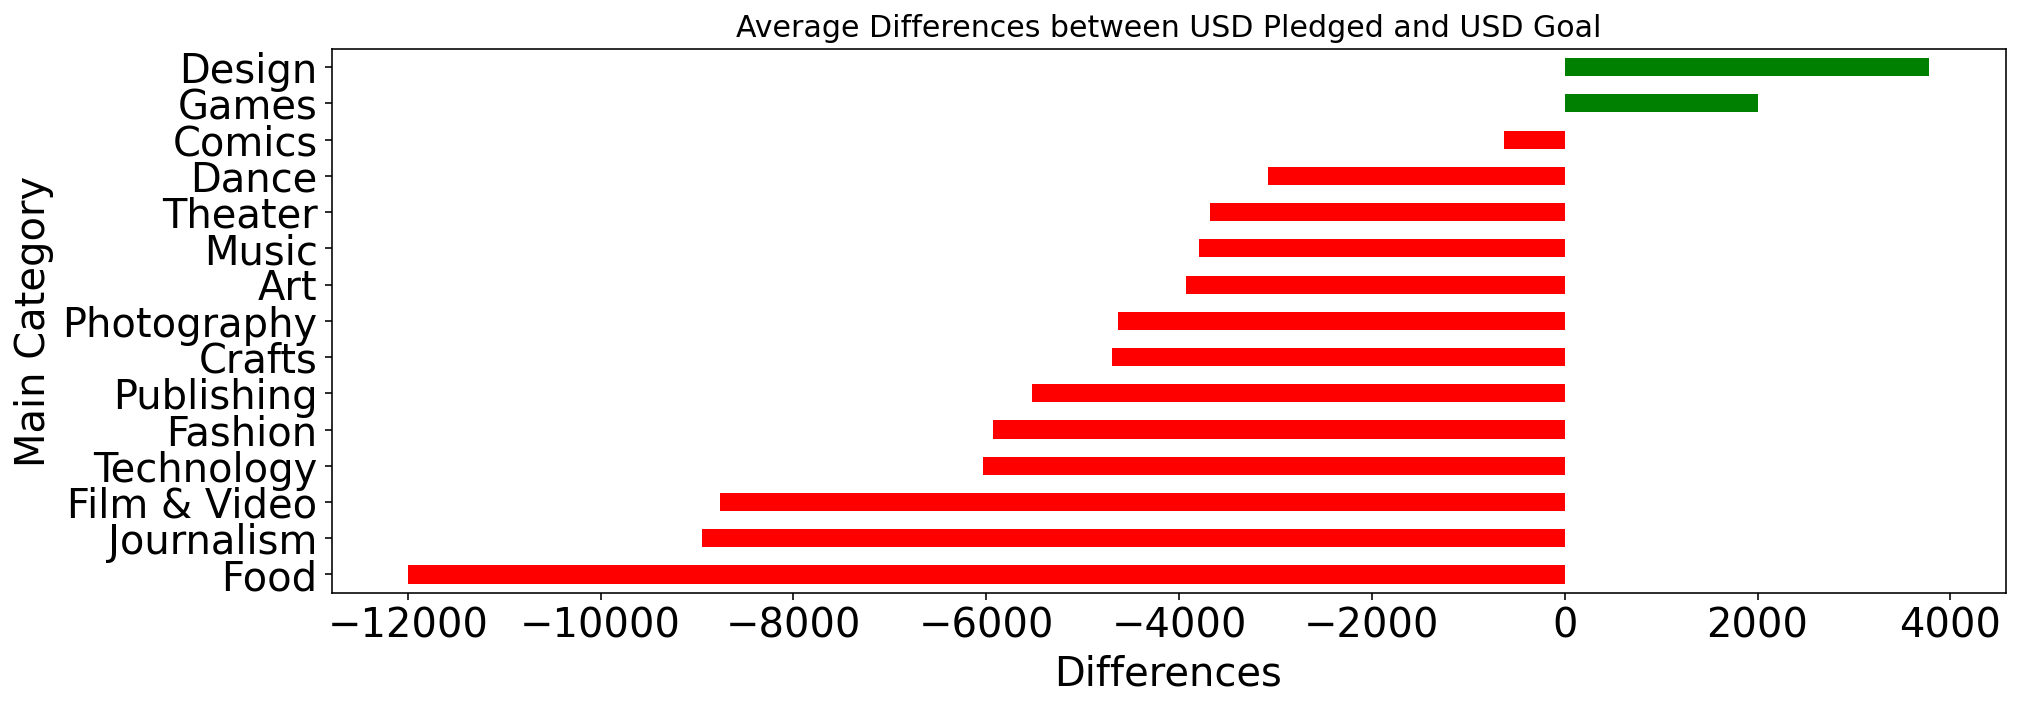

In [24]:
ks_subset_diff = goal_subset.groupby('main_category').mean().sort_values(by = 'difference')
ks_subset_diff['difference'].plot(kind='barh',
                    color=(ks_subset_diff['difference'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.title('Average Differences between USD Pledged and USD Goal', fontsize = 15)
plt.xlabel('Differences')
plt.ylabel('Main Category')
plt.show()

- Here we see that Design and Games are the only two categories with average difference being positive. 
- The average difference of Technology has increased

### Goal and Pledged Amount Visualization

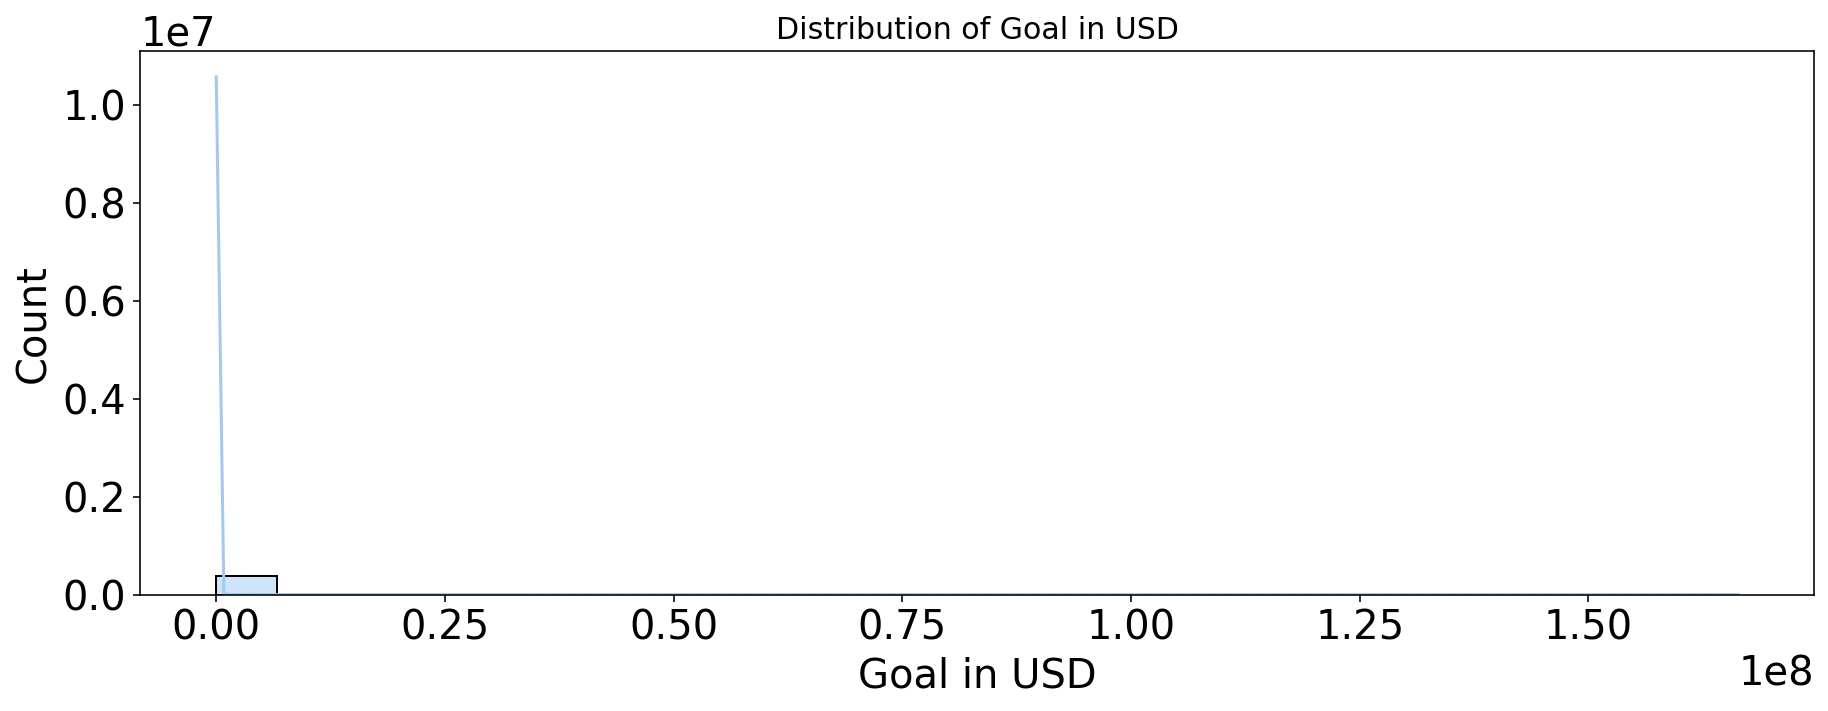

In [25]:
# distribution of funding goal 
sns.histplot(ks_projects['usd_goal_real'],bins = 25, kde=True)
plt.title('Distribution of Goal in USD', fontsize = 15)
plt.xlabel('Goal in USD')
plt.show()

In [26]:
# looking at outliers
ks_projects[ks_projects['usd_goal_real']== ks_projects.usd_goal_real.max()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop,difference
47803,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,GBP,2014-08-08,99000000.0,2014-07-09,0.0,failed,0,GB,0.0,1.663614e+08,30,0.0,-1.663614e+08


- Based on the unrealistic goal and name of the project, this campaign does not seem legitimate

<function matplotlib.pyplot.show(close=None, block=None)>

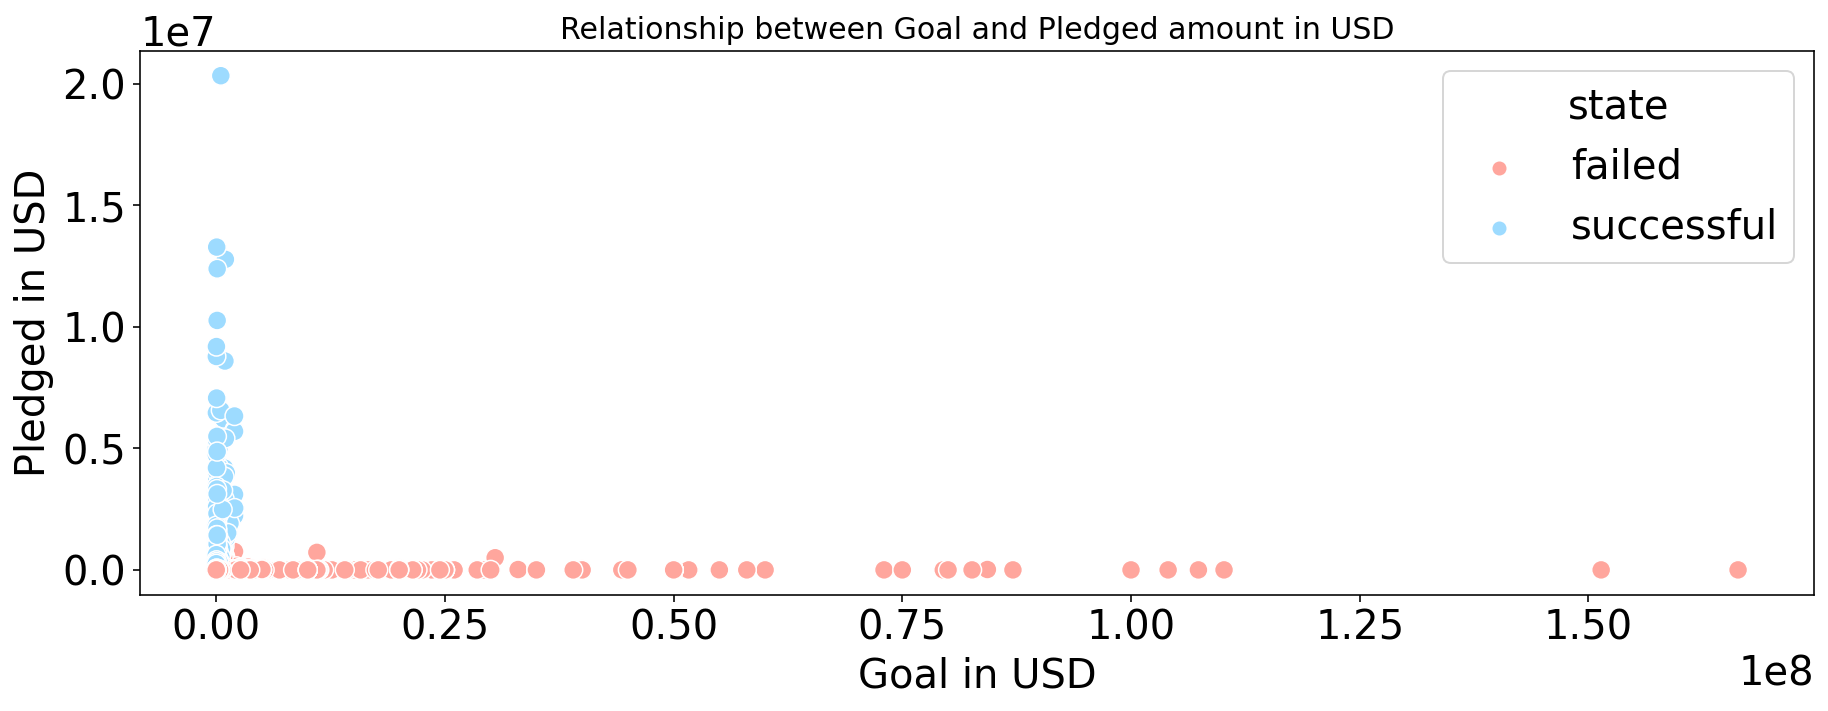

In [27]:
# relationship between goal and pledged
ax = sns.scatterplot(x = 'usd_goal_real', y = 'usd_pledged_real',hue = 'state', data = ks_state,
                     palette = ['#FFA69D' ,'#9DDBFF'], s = 90)
plt.xlabel('Goal in USD')
plt.ylabel('Pledged in USD')
plt.title('Relationship between Goal and Pledged amount in USD', fontsize = 15)
plt.show

 - The successful campaigns have much lower goal amounts than the failed campaigns

Text(0.5, 1.0, 'Distribution of Proportion Pledged')

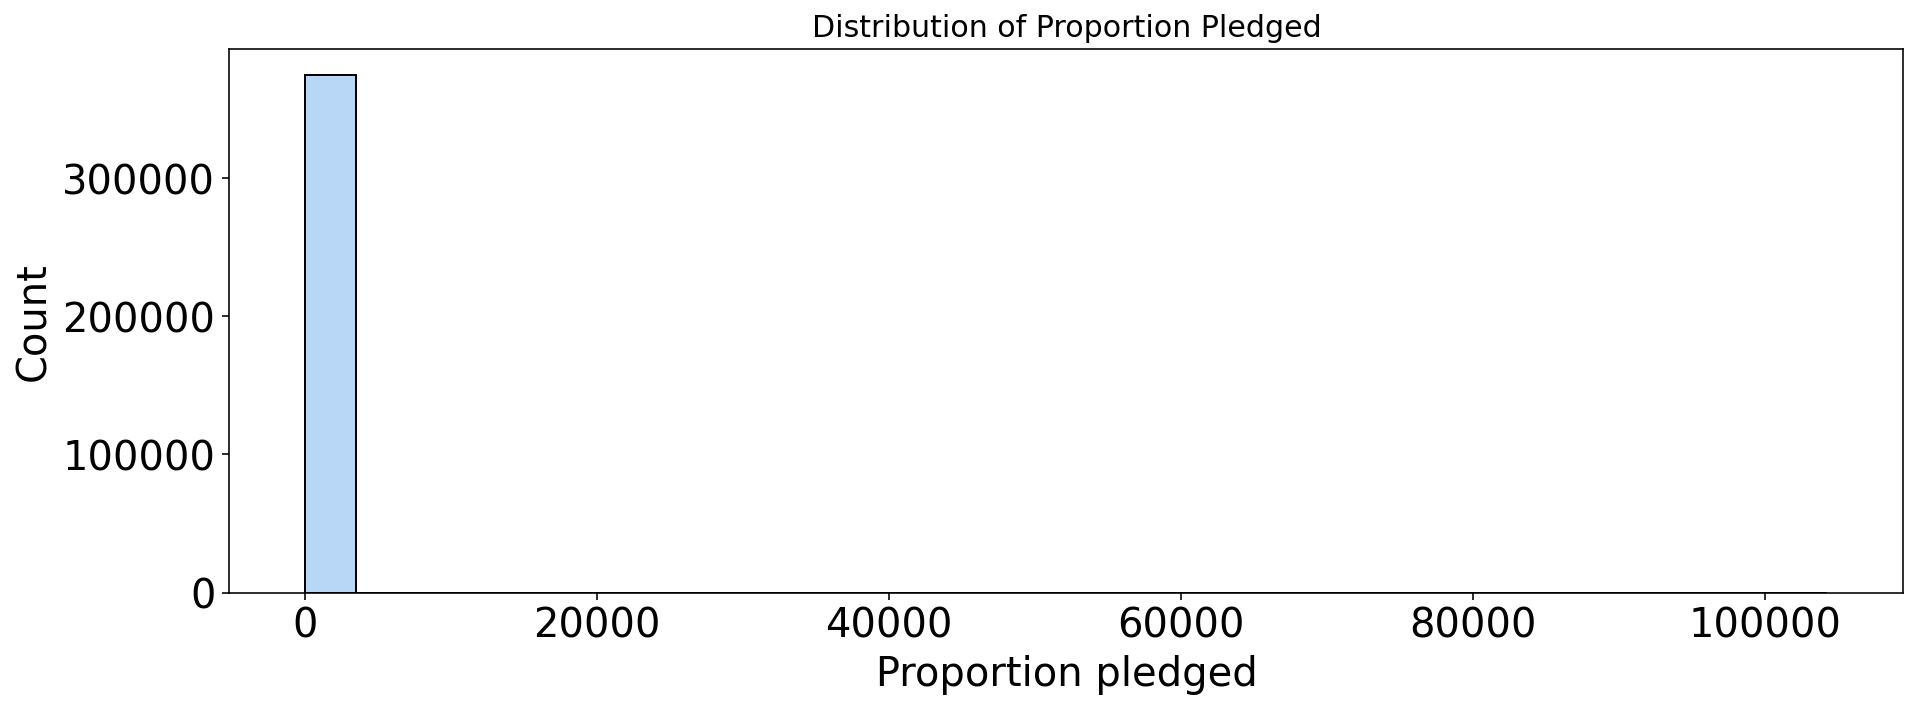

In [28]:
# check distribution of proportion pledged (also indicates success if >= 1)
sns.histplot(x = 'pledged_prop', data = ks_projects, bins = 30)
plt.xlabel('Proportion pledged')
plt.title('Distribution of Proportion Pledged', fontsize = 15)

In [29]:
ks_projects[ks_projects.pledged_prop == ks_projects.pledged_prop.max()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop,difference
369176,9509582,VULFPECK /// The Beautiful Game,Music,Music,USD,2016-10-17,1.0,2016-08-18,104277.89,successful,3917,US,104277.89,1.0,60,104277.89,104276.89


- The goal amount is 1 USD while the pledged amount is 104277.89. This is an outlier for the proportion pledged.

### Focusing on 'successful', 'failed' states

<AxesSubplot:title={'center':'Proportion of Success'}, xlabel='State of Campaign', ylabel='count'>

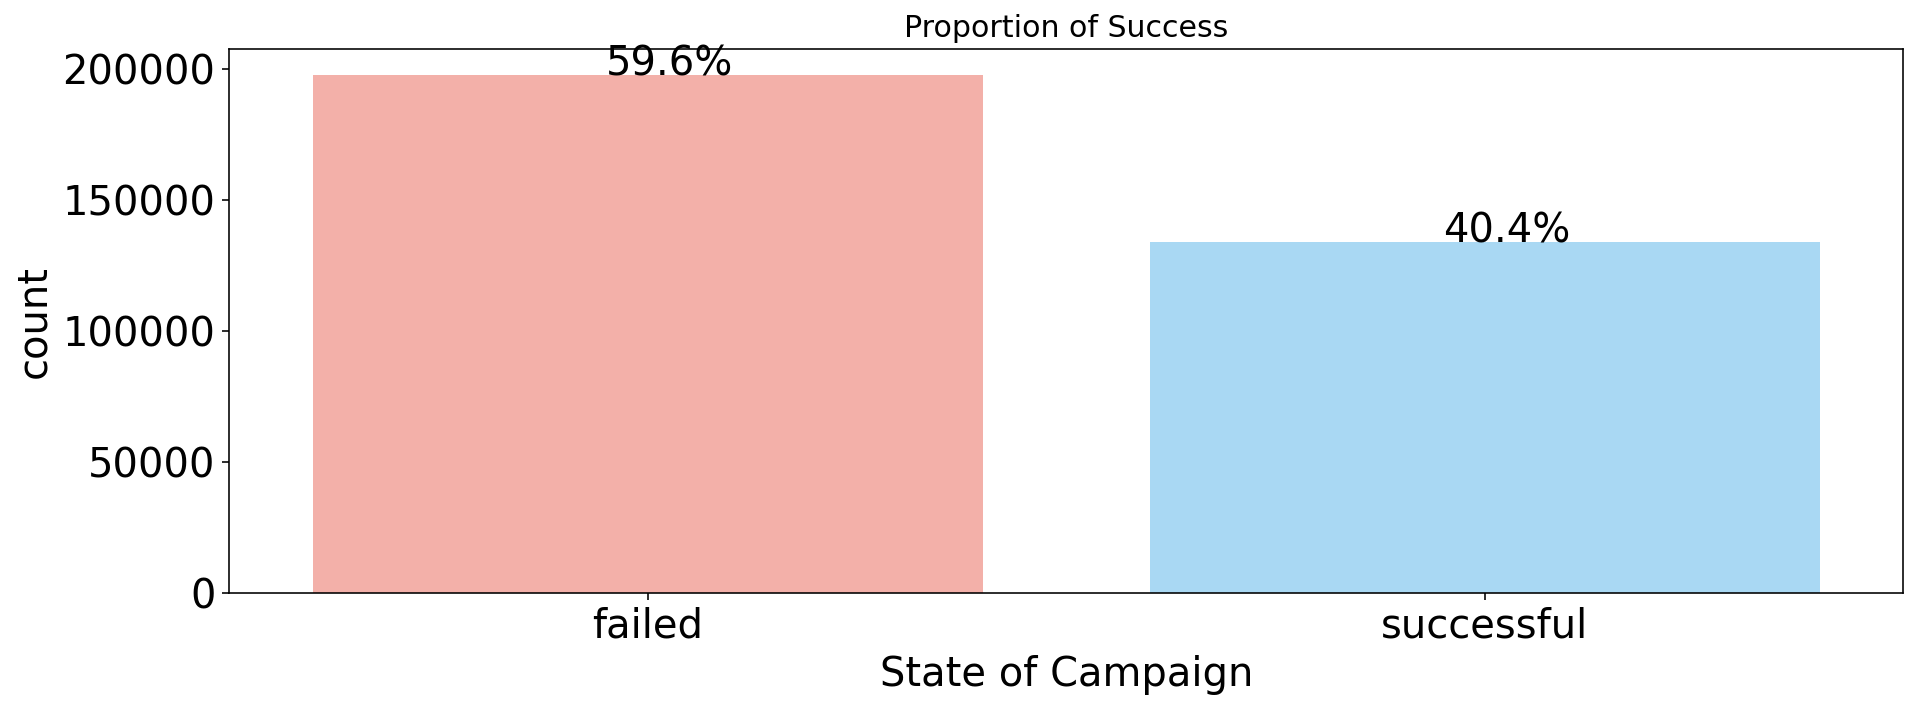

In [30]:
# Count each state: failed, successful, live
ax = sns.countplot(x = 'state', data=ks_state, palette = ['#FFA69D' ,'#9DDBFF'] )
plt.title('Proportion of Success', fontsize = 15)
plt.xlabel('State of Campaign')
total = float(len(ks_state))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y),ha='left')
ax


By looking at the countplot, we have the most number of `failed` projects in our dataset; `successful` projects follow, respectively.

#### We now have a general understanding of major features we are going to use for our project. Let's take a look at the relationships between different features.


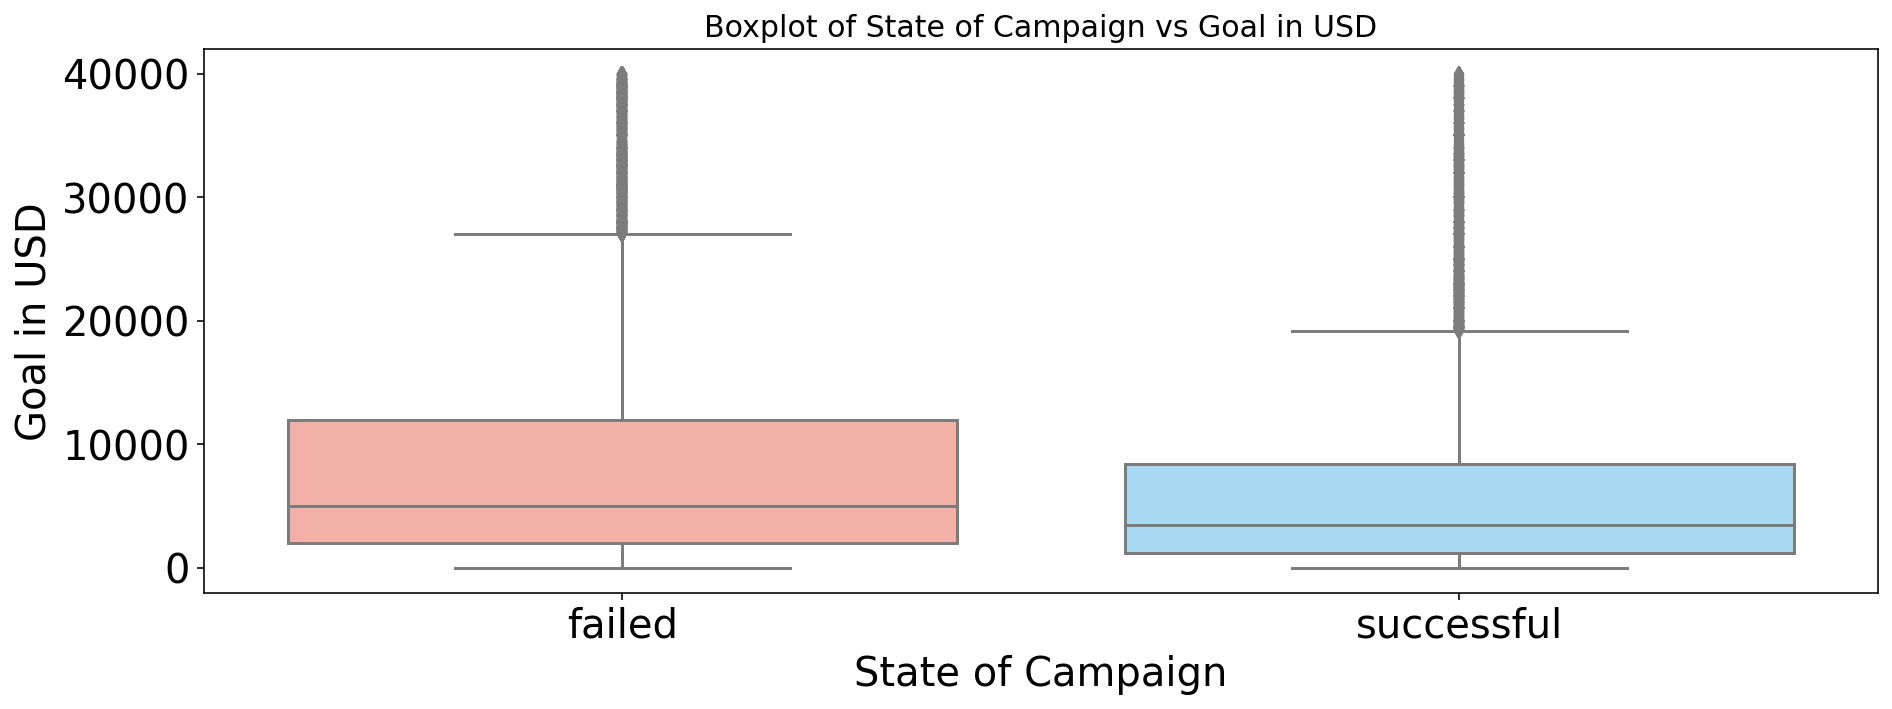

In [31]:
q90 = ks_state['usd_goal_real'].quantile(q=0.90, interpolation='nearest')
goal = ks_state[ks_state['usd_goal_real']<q90]
ax = sns.boxplot(x=ks_state['state'], y=goal['usd_goal_real'], palette = ['#FFA69D' ,'#9DDBFF'] )
plt.title('Boxplot of State of Campaign vs Goal in USD', fontsize = 15)
plt.xlabel('State of Campaign')
plt.ylabel('Goal in USD')
plt.show()


We keep 90 percentile of the data using quantile so that we remove outliers. These boxplots inform you a summary of the relationship between the two variables. We can now get a sense of where its central value is, and its variability.

Text(0.5, 1.0, 'Boxplot of Goal in USD per Country')

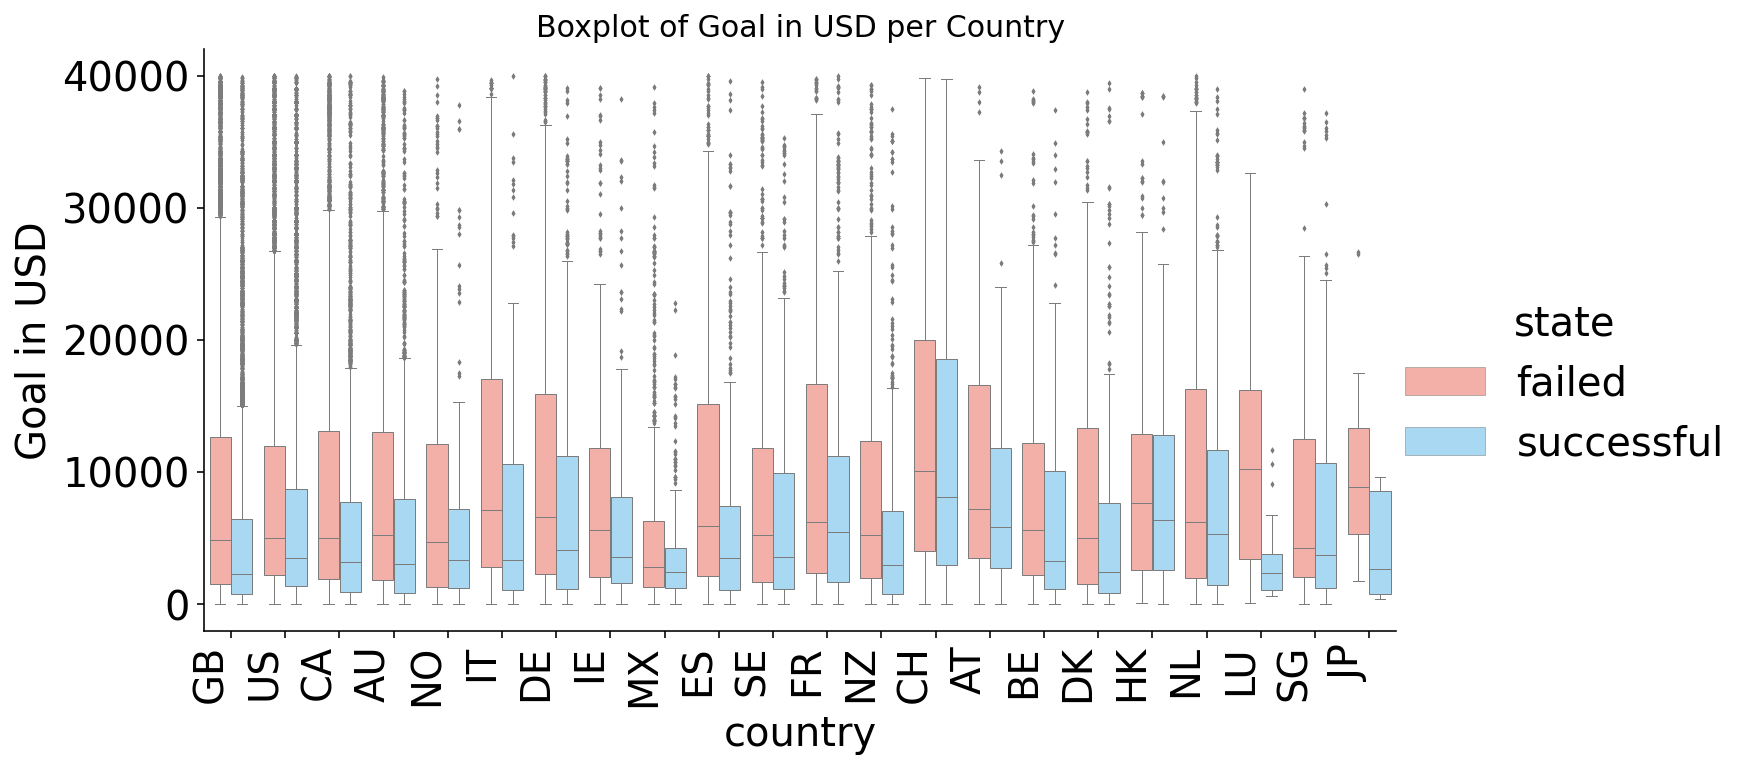

In [32]:
sns.catplot(x='country', y=goal['usd_goal_real'],hue='state', data=ks_state,
           kind = 'box', linewidth = 0.5, fliersize = 1,
           aspect = 2, palette = ['#FFA69D' ,'#9DDBFF'])
plt.xticks(rotation = 90, ha = 'right')
plt.ylabel('Goal in USD')
plt.title('Boxplot of Goal in USD per Country', fontsize = 15)

<AxesSubplot:title={'center':'Boxplot of State of Campaign vs Goal in USD'}, xlabel='State of Campaign', ylabel='Goal in USD'>

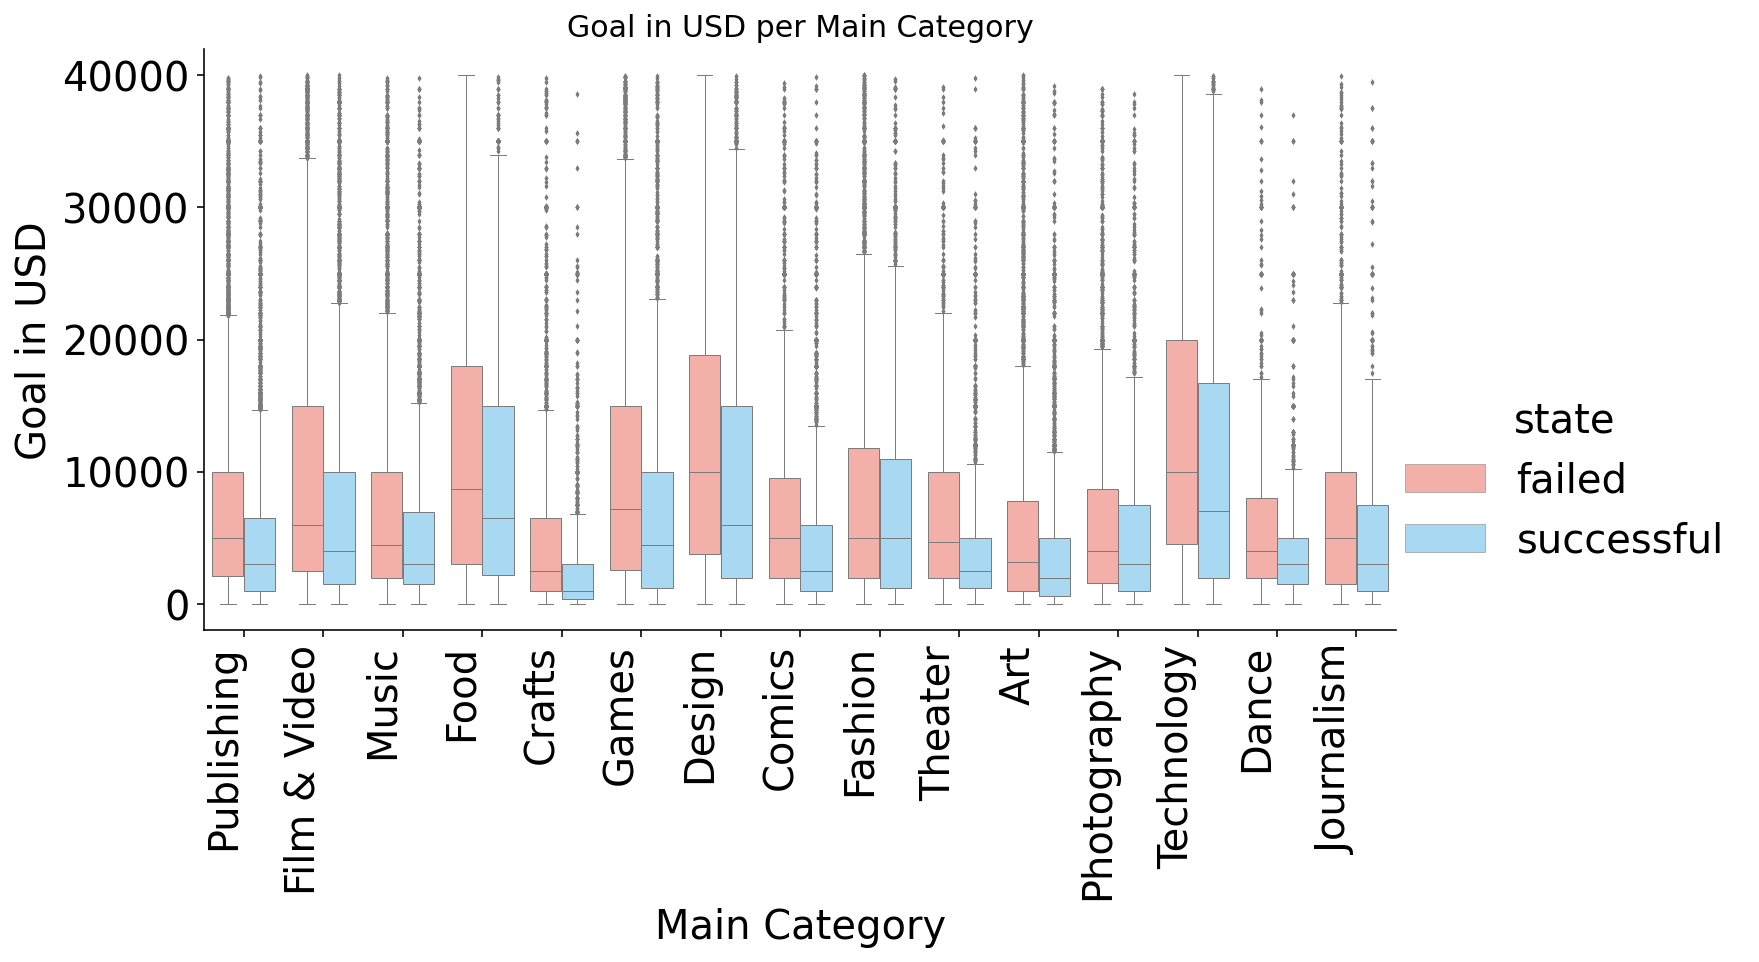

In [33]:
sns.catplot(x='main_category', y=goal['usd_goal_real'],hue='state', data=ks_state,
           kind = 'box', linewidth = 0.5, fliersize = 1,
           aspect = 2, palette = ['#FFA69D' ,'#9DDBFF'])
plt.xticks(rotation = 90, ha = 'right')
plt.xlabel('Main Category')
plt.ylabel('Goal in USD')
plt.title('Goal in USD per Main Category', fontsize = 15)
ax

Through these boxplots, we can see the relationship between the three variables. 
The graphs show how the state changes according to the usd_goal_real in which state or vice versa.

- Each middle line in the box is the median which tell us the typical `usd_goal_real` for `failed` and `successful`
- The median of `usd_goal_real` in the state of successful is under $10000
- add more interpretation 

## Analysis

In [34]:
#removing the outlier
ks_state = ks_state[ks_state['usd_goal_real']!= ks_state.usd_goal_real.max()]
ks_state = ks_state.dropna()
ks_state.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59,0.000000
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60,0.080700
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45,0.004889
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30,0.000200
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,50000.00,35,1.047500


### T-test to compare mean Goal for Successful vs Failed projects

A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features. In this case, we are using it to check for a significant difference in the mean goal between the 'successful' and 'failed' states.

In [35]:
success = ks_state[ks_state.get('state') == 'successful']['usd_goal_real']

fail = ks_state[ks_state.get('state') == 'failed']['usd_goal_real']
t_val, p_val = stats.ttest_ind(success, fail)
print("T-value: ", t_val)
print("P-value: ", p_val)

T-value:  -13.933729463273446
P-value:  4.0668023956863094e-44


* Given a p-value as small as 4.0668 x 10^-44, we can conclude that there does exist a significant difference in the average goal amount between the two states (successful and failed projects).

## Chi-Squared Test (State & Location)

In [36]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

"Chi-Squared Test" also known as "Good of Fit" are normally used to test if two categorical variables are associated to each other. <br>
In the first chi-squared test, we are testing to see the relationship between the two categorical variables: state (Success & Fail) and location (different countries).

- Null Hypothesis: The two categorical variables, State & Location, are independent of each other.
- Alternative Hypothesis: The two categorical variables, State & Location, are not independent of each other.

In [37]:
# Significance Level
alpha = 0.05

To run the chi-squared test, we convert the data into a contingency table with frequencies. <br>
For the chi-squared test, we are using the crosstab command from pandas.

In [38]:
state_location_contingency = pd.crosstab(ks_state['state'], ks_state['country'])

In [39]:
state_location_contingency

country,AT,AU,BE,CA,CH,DE,DK,ES,FR,GB,...,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
state,,,,,,,,,,,,,,,,,,,,,
failed,378,4606,371,8236,465,2499,566,1381,1612,17385,...,1930,16,38,1015,1794,420,826,1000,276,152059
successful,107,2010,152,4134,187,937,360,492,908,12067,...,439,7,19,396,617,162,448,509,178,109299


We want to generate the percentages by state (successful and failed). <br> 
Setting normalize = 'column' to have the percentages by column.

In [40]:
state_location_contingency_pct = pd.crosstab(ks_state['state'], ks_state['country'], normalize='index')

In [41]:
state_location_contingency_pct

country,AT,AU,BE,CA,CH,DE,DK,ES,FR,GB,...,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
state,,,,,,,,,,,,,,,,,,,,,
failed,0.001913,0.023309,0.001877,0.041678,0.002353,0.012646,0.002864,0.006989,0.008157,0.087976,...,0.009767,0.000081,0.000192,0.005136,0.009078,0.002125,0.004180,0.005060,0.001397,0.769490
successful,0.000799,0.015017,0.001136,0.030885,0.001397,0.007000,0.002690,0.003676,0.006784,0.090152,...,0.003280,0.000052,0.000142,0.002959,0.004610,0.001210,0.003347,0.003803,0.001330,0.816572


We generate the heatmaps to visually see the contingency tables.

<AxesSubplot:xlabel='country', ylabel='state'>

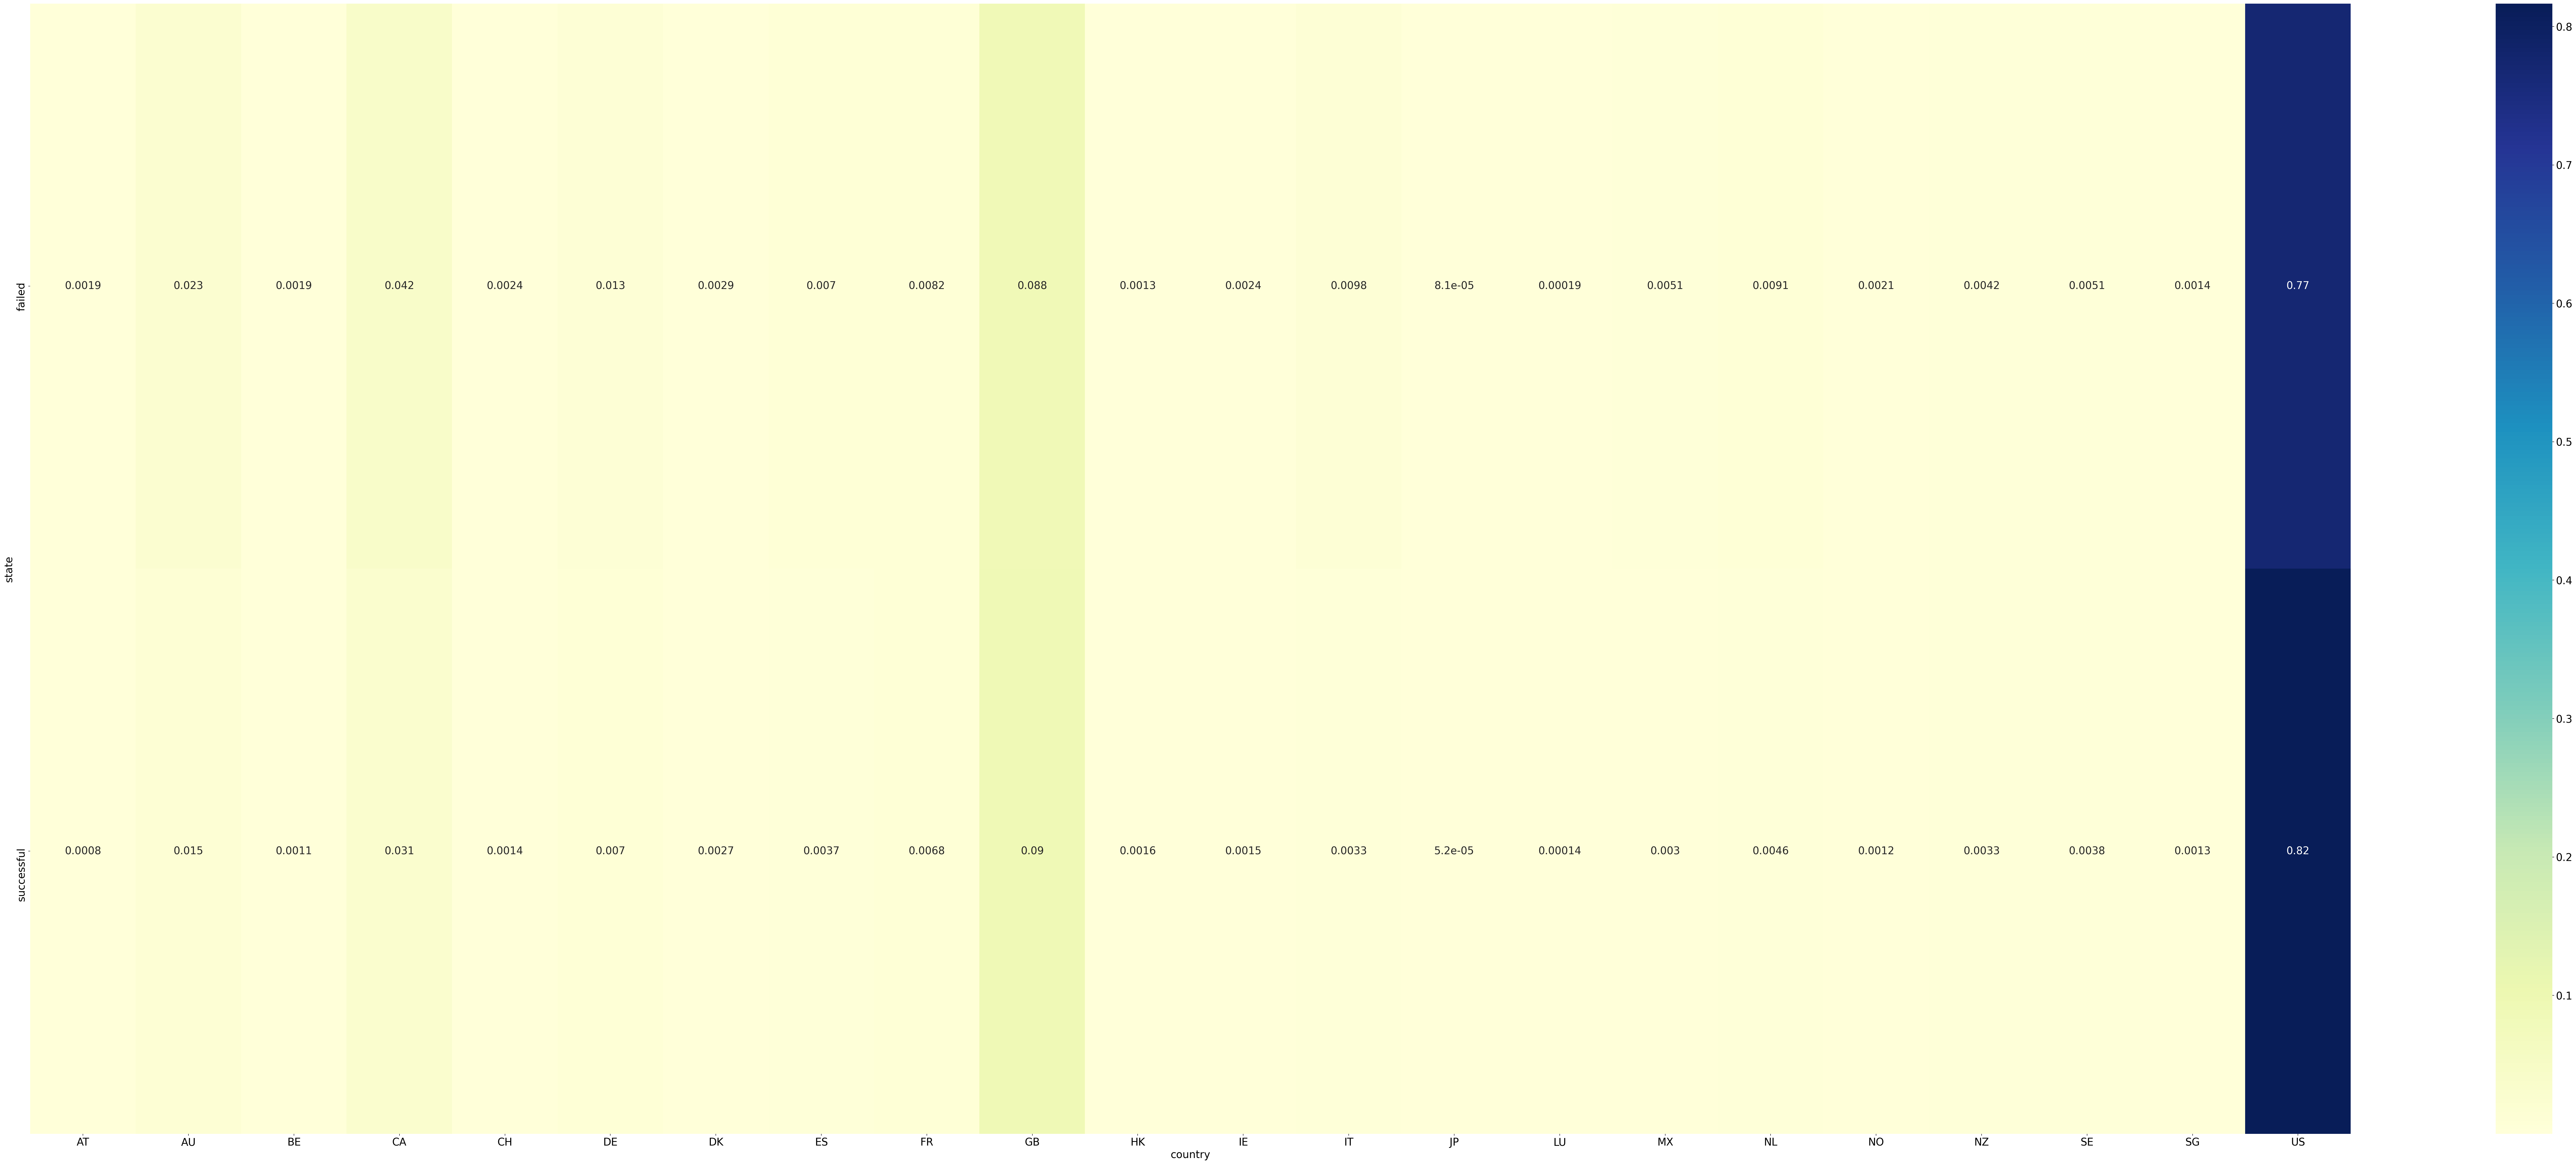

In [42]:
plt.figure(figsize=(100,40))
sns.heatmap(state_location_contingency_pct, annot = True, cmap="YlGnBu")

- chi2: The test statistic
- p: The p-value of the test
- dof: Degrees of freedom
- expected: The expected frequencies, based on the marginal sums of the table

In [43]:
# Chi-square test of independence
c, p, dof, expected = chi2_contingency(state_location_contingency)

In [44]:
print('significance=%.2f, p=%.3f' % (alpha, p))
if p <= alpha:
    print("The p-value is %.3f is lower than the significance level, alpha = 0.05, which means that the variables are associated with each other. \nTherefore, we are rejecting the null hypothesis." %(p))
#     print("Variables are associated (reject H0)")
else:
#     print("Variables are not associated (fail to reject H0)")
    print("The p-value is %.3f is higher than the significance level, alpha = 0.05, which means that the variables are not associated with each other. \n Therefore, we failed reject the null hypothesis" %(p))

significance=0.05, p=0.000
The p-value is 0.000 is lower than the significance level, alpha = 0.05, which means that the variables are associated with each other. 
Therefore, we are rejecting the null hypothesis.


Since the p-value (tending to 0), is less than our significance level, 0.05, we should reject the null hypothesis which means that there is association between state (success & fail) and location (different countries). However, we would also like to point out that our dataset is quite large which means that the slightest difference could result in this p-value.

## Chi-Square Test (State & Category)

- Null Hypothesis: The two categorical variables, State & Main_Category, are independent of each other.
- Alternative Hypothesis: The two categorical variables, State & Main_Category, are not independent of each other.

In [45]:
# Significance Level
alpha = 0.05

In [46]:
state_category_contingency = pd.crosstab(ks_state['state'], ks_state['main_category'])

In [47]:
state_category_contingency

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
failed,14130,4036,5703,1235,14814,14181,32891,15968,16002,3136,21696,6384,23113,20613,3708
successful,11510,5842,2115,2338,10549,5593,23612,6085,12518,1012,24105,3305,12300,6433,6534


In [48]:
state_category_contingency_pct = pd.crosstab(ks_state['state'], ks_state['main_category'], normalize = 'index')

In [49]:
state_category_contingency_pct

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
failed,0.071504,0.020424,0.028860,0.006250,0.074966,0.071763,0.166444,0.080806,0.080978,0.015870,0.109792,0.032306,0.116963,0.104312,0.018764
successful,0.085991,0.043646,0.015801,0.017467,0.078812,0.041785,0.176405,0.045461,0.093522,0.007561,0.180088,0.024692,0.091893,0.048061,0.048815


<AxesSubplot:xlabel='main_category', ylabel='state'>

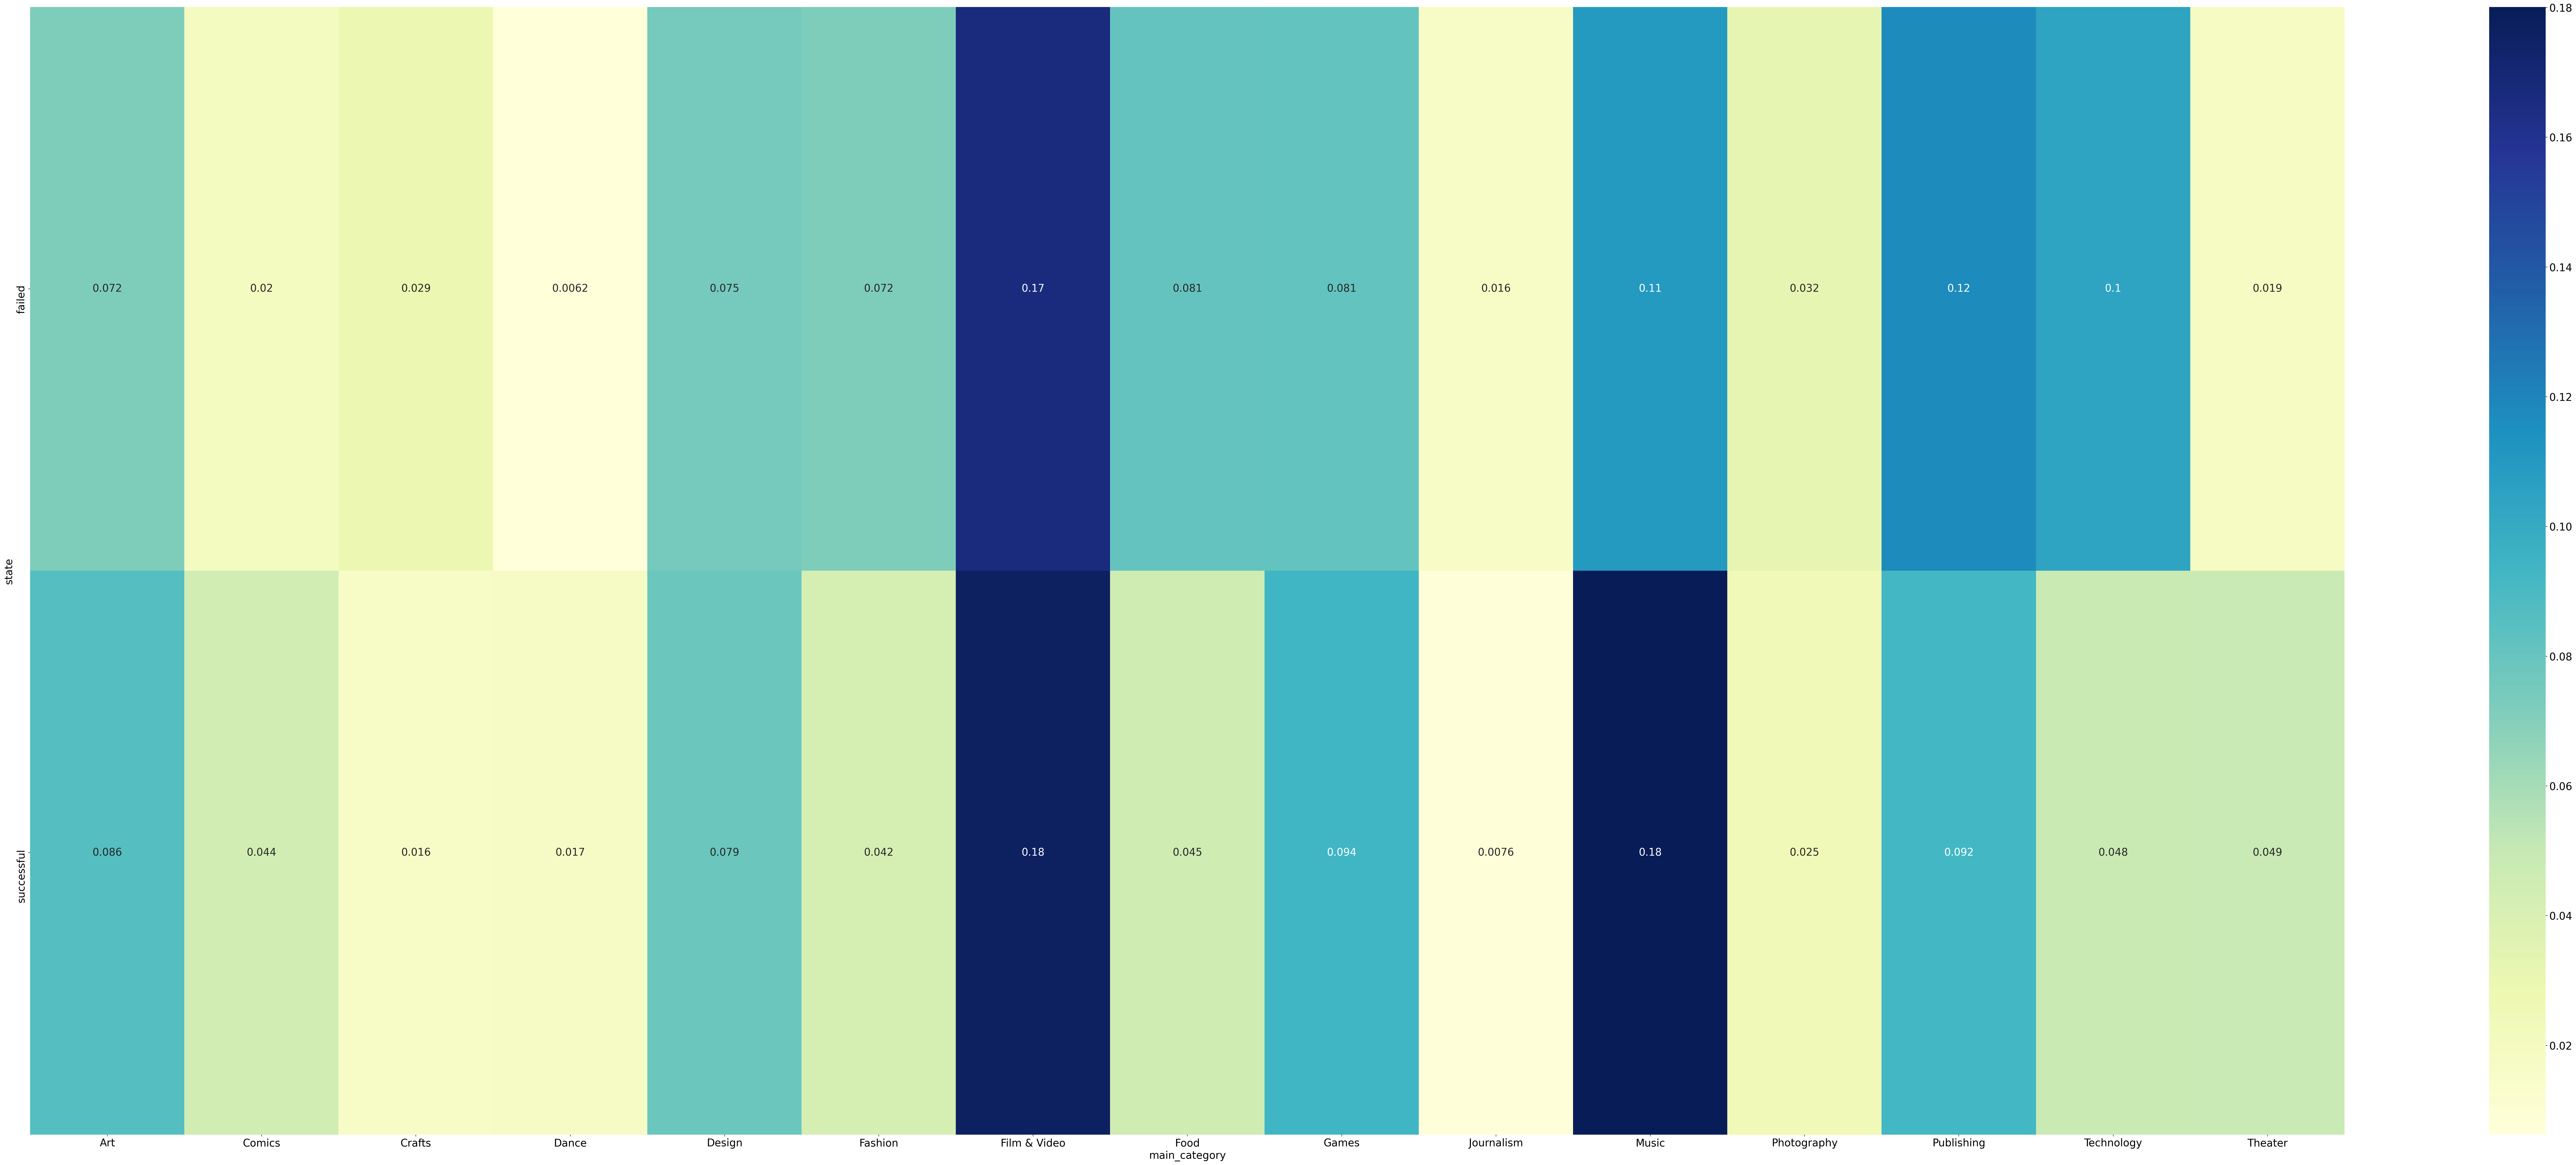

In [50]:
plt.figure(figsize=(100,40))
sns.heatmap(state_category_contingency_pct, annot = True, cmap="YlGnBu")

In [51]:
# Chi-square test of independence
c2, p2, dof2, expected2 = chi2_contingency(state_category_contingency)

In [52]:
print('significance=%.2f, p=%.3f' % (alpha, p2))
if p2 <= alpha:
    print("The p-value is %.3f is lower than the significance level, alpha = 0.05, which means that the variables are associated to each other. \nTherefore, we are rejecting the null hypothesis." %(p2))
#     print("Variables are associated (reject H0)")
else:
#     print("Variables are not associated (fail to reject H0)")
    print("The p-value is %.3f is higher than the significance level, alpha = 0.05, which means that the variables are not associated to each other. \n Therefore, we failed reject the null hypothesis" %(p2))

significance=0.05, p=0.000
The p-value is 0.000 is lower than the significance level, alpha = 0.05, which means that the variables are associated to each other. 
Therefore, we are rejecting the null hypothesis.


Since the p-value (tending to 0), is less than our significance level, 0.05, we should reject the null hypothesis which means that there is association between state (success & fail) and main_category (different categories). However, we would also like to point out that our dataset is quite large which means that the slightest difference could result in this p-value.

### Logistic Regression
In the case of a bivariate dependent variable (group 1 or 0), general linear regression analysis is not suitable. Logistic regression is an analysis that can be used even if it has the characteristic of a bivariate dependent variable. Logistic regression analysis refers to an analysis for classification prediction that estimates the categories to belong to quantitative independent variables and categorical or nominal bivariate dependent variables (group 1 or 0).
Since in our case, we have a binary outcome for the 'state' variable, i.e, 'successful' or 'failed', we decided to start modelling using Logistic Regression.

### Logistic regression for `usd_goal_real` and `state`

In [53]:
X = ks_state[['usd_goal_real']]
Y = ks_state['state'].apply(lambda x: 1 if x == 'successful' else 0)
logit = sm.Logit(Y.to_frame()['state'],X) 
result = logit.fit()

C:\Users\Gauri\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.655201
         Iterations 9


In [54]:
result.summary()

C:\Users\Gauri\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331461
Model:                          Logit   Df Residuals:                   331460
Method:                           MLE   Df Model:                            0
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:                 0.02866
Time:                        22:22:05   Log-Likelihood:            -2.1717e+05
converged:                       True   LL-Null:                   -2.2358e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
usd_goal_real  -2.16e-05   1.88e-07   -114.791      0.000    -2.2e-05   -2.12e-05
=================================================================================
"""

Result indicates that each one-unit change in `usd_goal_real` will increase the log odds of being success by -2.16e-05. In other words, the lower the value of `usd_goal_real`, the higher the probability of success. 

Converting the estimate onto the odds ratio scale is as simple as exponentiating the parameter estimate.

In [55]:
np.exp(result.params)

usd_goal_real    0.999978
dtype: float64

Coefficient of `usd_goal_real` is less than 1 indicates that decreasing in the probability of success when `usd_goal_real` will increase. 
Therefore, lower funding goal lead to a higher chance of success. 

### Logistic regression for `country` and `state`


In [56]:
country_transformed = pd.get_dummies(ks_state, columns = ['country'] 
               , drop_first=True)

# removing unnecessary columns
country_transformed.columns
country_transformed = country_transformed.drop(['ID', 'name', 'pledged_prop', 'category', 'currency', 'deadline', 'goal', 'launched',
            'pledged', 'state', 'backers', 'usd_pledged_real', 'usd_goal_real',
            'duration', 'main_category'], axis = 1)

country_transformed.head()

,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
X = country_transformed
Y = ks_state['state'].apply(lambda x: 1 if x == 'successful' else 0)
logit = sm.Logit(Y.to_frame()['state'],X) 
res_cntry_state = logit.fit()

Optimization terminated successfully.
         Current function value: 0.671277
         Iterations 5


In [59]:
print(res_cntry_state.summary())

                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:               331461
Model:                          Logit   Df Residuals:                   331440
Method:                           MLE   Df Model:                           20
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:                0.004823
Time:                        22:24:07   Log-Likelihood:            -2.2250e+05
converged:                       True   LL-Null:                   -2.2358e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
country_AU    -0.8292      0.027    -31.019      0.000      -0.882      -0.777
country_BE    -0.8923      0.096     -9.266      0.000      -1.081      -0.704
country_CA    -0.6893      0.019    -36.162      0.0

Converting the estimate onto the odds ratio scale is as simple as exponentiating the parameter estimate.

In [60]:
np.exp(res_cntry_state.params)

country_AU    0.436387
country_BE    0.409704
country_CA    0.501943
country_CH    0.402151
country_DE    0.374950
country_DK    0.636042
country_ES    0.356264
country_FR    0.563275
country_GB    0.694104
country_HK    0.827586
country_IE    0.434874
country_IT    0.227461
country_JP    0.437500
country_LU    0.500000
country_MX    0.390148
country_NL    0.343924
country_NO    0.385714
country_NZ    0.542373
country_SE    0.509000
country_SG    0.644928
country_US    0.718793
dtype: float64

By observing these values, we notice that Hong Kong has the highest odds ratio(0.827586) and least negative coefficient (-0.1892) whereas Italy has the lowest odds ratio (0.227461) and most negative coefficient (-1.4808).This is consistent with the EDA graph of the proportion of successful campgains by country. 

Hong Kong does have the highest success ratio in our dataset, while Italy has the lowest. However, our R-squared value is very close to 0, indicating that this model does not explain the variability in the outcome (state of the project) accurately.


### Logistic regression for `main_category` and `state`


In [61]:
ctgry_transformed = pd.get_dummies(ks_state, columns = ['main_category'] 
               , drop_first=True)

# removing unnecessary columns
ctgry_transformed.columns
ctgry_transformed = ctgry_transformed.drop(['ID', 'name', 'pledged_prop', 'category', 'currency', 'deadline', 'goal', 'launched',
            'pledged', 'state', 'backers', 'usd_pledged_real', 'usd_goal_real',
            'duration', 'country'], axis = 1)

ctgry_transformed.head()

,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [62]:
X = ctgry_transformed
Y = ks_state['state'].apply(lambda x: 1 if x == 'successful' else 0)
logit = sm.Logit(Y.to_frame()['state'],X) 
res_ctgry_state = logit.fit()

Optimization terminated successfully.
         Current function value: 0.651300
         Iterations 5


In [63]:
print(res_ctgry_state.summary())

                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:               331461
Model:                          Logit   Df Residuals:                   331447
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Mar 2021   Pseudo R-squ.:                 0.03444
Time:                        22:25:06   Log-Likelihood:            -2.1588e+05
converged:                       True   LL-Null:                   -2.2358e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
main_category_Comics           0.3698      0.020     18.068      0.000       0.330       0.410
main_category_Crafts          -0.9919      0.025    -38.962      0.000      -1.042 

Converting the estimate onto the odds ratio scale is as simple as exponentiating the parameter estimate.

In [64]:
np.exp(res_ctgry_state.params)

main_category_Comics          1.447473
main_category_Crafts          0.370857
main_category_Dance           1.893117
main_category_Design          0.712097
main_category_Fashion         0.394401
main_category_Film & Video    0.717886
main_category_Food            0.381075
main_category_Games           0.782277
main_category_Journalism      0.322704
main_category_Music           1.111034
main_category_Photography     0.517701
main_category_Publishing      0.532168
main_category_Technology      0.312085
main_category_Theater         1.762136
dtype: float64

By observing these values, we notice that Dance has the highest odds ratio(1.893117) and highest coefficient (0.6382) whereas Italy has the lowest odds ratio (0.312085) and most negative coefficient (-1.1645).This is consistent with the EDA graph of the proportion of successful campgains by main category. 

Dance does have the highest success ratio in our dataset, while Technology has the lowest. However, our R-squared value is very close to 0, indicating that this model does not explain the variability in the outcome (state of the project) accurately.

## Linear Regression

In statistics, linear regression is a linear approach to modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables).

We have determined from our above statistical analyses that Hong Kong and Dance have the highest proportions of success. However, we want to determine how significant these results are and find the strength of the relationship between country/main_category and success.

### Multi-collinearity Check for the Features

Before moving forward with our linear modelling, we decided to ensure that there was little to no correlation(dependency) between the features we were trying to analyze. Thus, we created a correlational matrix with the features. 

In [65]:
#creating subsets for correlational matrices
target_col = 'pledged_prop'
target = ks_state[target_col]
ks_subset = ks_state.drop(columns = ['pledged_prop', 'duration', 'backers', 'state', 'pledged', 'goal', 'launched', 'currency', 'category', 'deadline', 'ID', 'usd_pledged_real', 'name'])
ks_subset.head()

,main_category,country,usd_goal_real
0,Publishing,GB,1533.95
1,Film & Video,US,30000.00
2,Film & Video,US,45000.00
3,Music,US,5000.00
5,Food,US,50000.00


In [66]:
#categorical features
catVars = ['main_category', 'country']
ks_subset_cat = ks_subset.drop(['main_category' , 'country'], axis = 1).copy()

In [67]:
#function to plot correlation between the features and the target
def plot_correlation(df, target):
    k = 10
    numerical_feature_columns = list(df._get_numeric_data().columns)
    cols = df[numerical_feature_columns].corr().nlargest(k, target)[target].index
    cm = df[cols].corr()
    plt.figure(figsize = (10, 6))
    heat_map = sns.heatmap(cm, annot = True, cmap = 'viridis', annot_kws={"size": 10})
    heat_map.set_xticklabels(heat_map.get_xmajorticklabels(), fontsize = 14)
    heat_map.set_yticklabels(heat_map.get_ymajorticklabels(), fontsize = 14)
    return heat_map

We encoded the categorical variables using Dummy Encoding in order to use it in our Linear Regression Models

In [68]:
#function to help convert categorical features
def encode_cat_var_fit_model(df, df_cat, catVars, target, clf, drop_one_col, plot_corr, target_col):
    if drop_one_col == 1:
        dummy_var = pd.get_dummies(df[catVars], drop_first = True)
    else:
        dummy_var = pd.get_dummies(df[catVars], drop_first = False)
    reg_df = pd.concat([df_cat, dummy_var], axis = 1)
    temp_reg_df = pd.concat([df_cat, dummy_var, target], axis = 1)
    if plot_corr == 1:
        plot_out = plot_correlation(temp_reg_df, target_col)
    model_fit = clf.fit(reg_df, target)
    r2 = clf.score(reg_df, target)
    print("R_squared value: ", r2)
    coeffs = pd.Series(model_fit.coef_)
    coef_dict = dict(zip(reg_df.columns, coeffs))
    return coef_dict

R_squared value:  0.0001233771849158405
Coefficients for Linear Regression: 

usd_goal_real : -0.0 

main_category_Comics : 4.142 

main_category_Crafts : 0.084 

main_category_Dance : -2.033 

main_category_Design : -0.252 

main_category_Fashion : -1.506 

main_category_Film & Video : -1.169 

main_category_Food : -1.85 

main_category_Games : 5.822 

main_category_Journalism : -2.006 

main_category_Music : 5.92 

main_category_Photography : -1.931 

main_category_Publishing : -0.829 

main_category_Technology : 0.684 

main_category_Theater : -1.647 

country_AU : 0.613 

country_BE : -0.435 

country_CA : 1.517 

country_CH : 0.277 

country_DE : 0.07 

country_DK : 0.155 

country_ES : -0.349 

country_FR : 1.284 

country_GB : 0.527 

country_HK : 1.418 

country_IE : 0.093 

country_IT : 0.299 

country_JP : -0.66 

country_LU : 0.207 

country_MX : 0.551 

country_NL : 0.014 

country_NO : -0.463 

country_NZ : 1.08 

country_SE : -0.056 

country_SG : 1.103 

country_US : 3.1

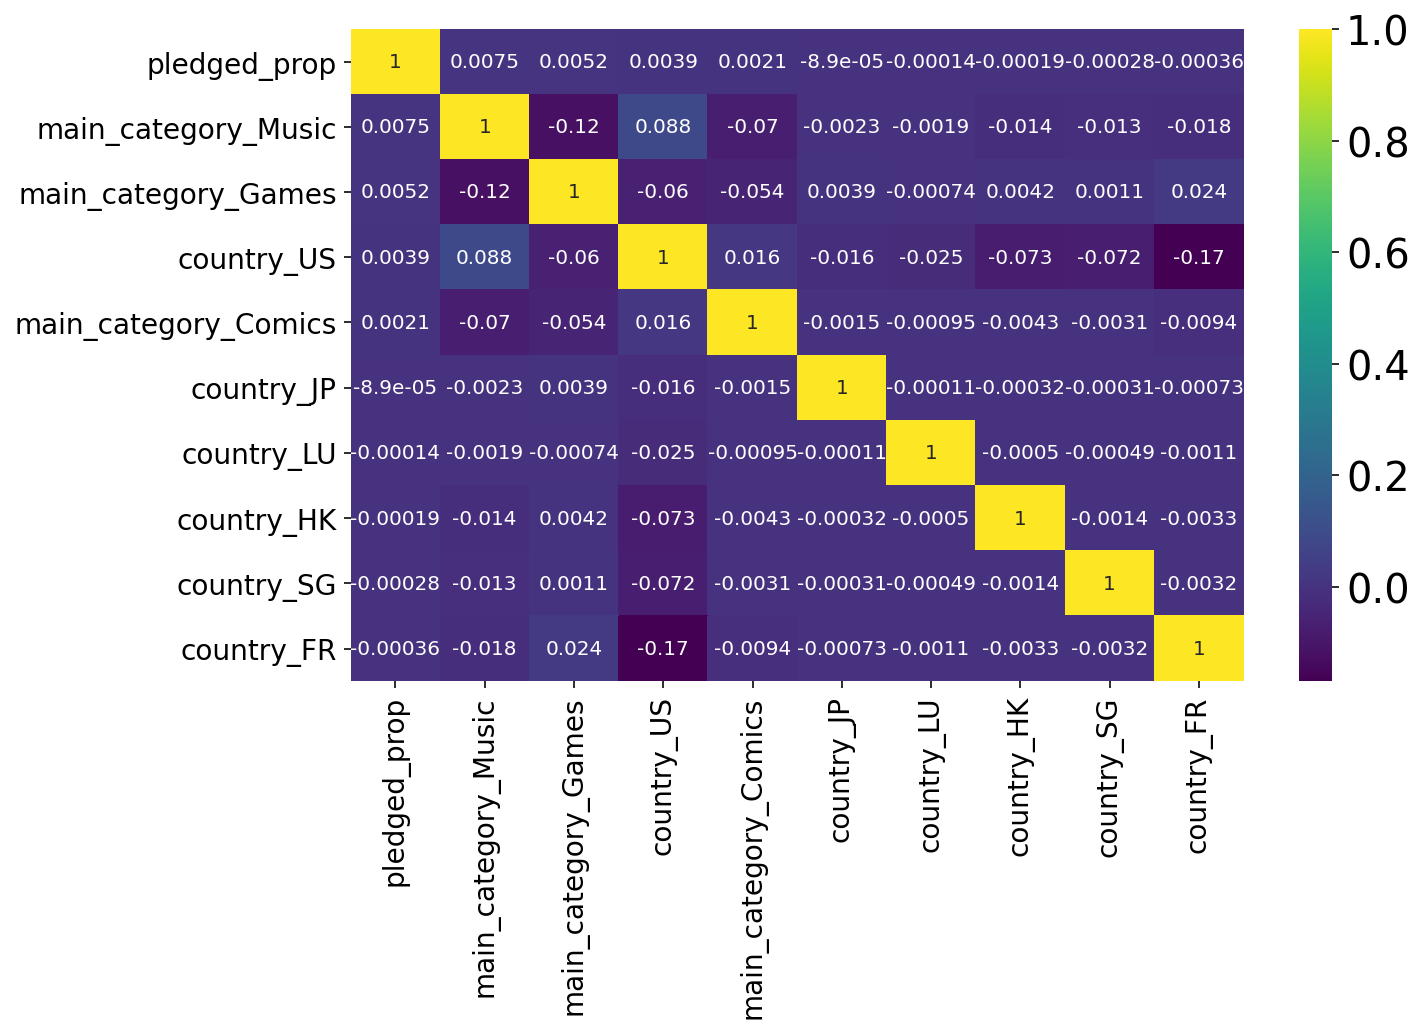

In [69]:
linear_reg = LinearRegression()
coeff_not_dropping_one_col = encode_cat_var_fit_model(ks_subset, ks_subset_cat, catVars, target, linear_reg, drop_one_col = 1, plot_corr = 1, target_col = target_col)
print('Coefficients for Linear Regression: \n')
for key, value in coeff_not_dropping_one_col.items():
    print(key, ':', round(value, 3), '\n')

* As we can see from the heatmap, there is no significant multicolinearlity in the fearures and thus, we can continue with our modelling process. The highest correlational value we notice is -0.17 for USA and France.

## Linear Modelling of the Features

### usd_goal_real, country and main_category vs state

In [70]:
#all features combined
outcome_1, predictors_1 = patsy.dmatrices('pledged_prop ~ usd_goal_real + country + main_category', ks_state)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:           pledged_prop   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.136
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.264
Time:                        22:25:34   Log-Likelihood:            -2.3411e+06
No. Observations:              331461   AIC:                         4.682e+06
Df Residuals:                  331424   BIC:                         4.683e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* The only noticeably significant p-values belong to the main_category values 'Games' and 'Music' with p-values 0.017 and 0.007 respectively. However, an R-squared value of 0 indicates that this particular model does not explain the variability along the mean well.

In [71]:
#only goal model
outcome_2, predictors_2 = patsy.dmatrices('pledged_prop ~ usd_goal_real', ks_state)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:           pledged_prop   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06509
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.799
Time:                        22:25:34   Log-Likelihood:            -2.3411e+06
No. Observations:              331461   AIC:                         4.682e+06
Df Residuals:                  331459   BIC:                         4.682e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5170      0.491      7.159

* The p-value is not significant. An R-squared value of 0 indicates that this particular model does not explain the variability along the mean well.

### Log transformation on usd_goal_real

We use proportion pledged as a continuous, quantitative measure of success as it is the amount of money pledged divided by the amount of money set as a goal. This determines success as any proportion >= 1 would mean more money was pledged than the goal and therefore, the campaign was successful.

Removing the outlier usd_goal_real value from the dataset

<AxesSubplot:xlabel='usd_goal_real', ylabel='pledged_prop'>

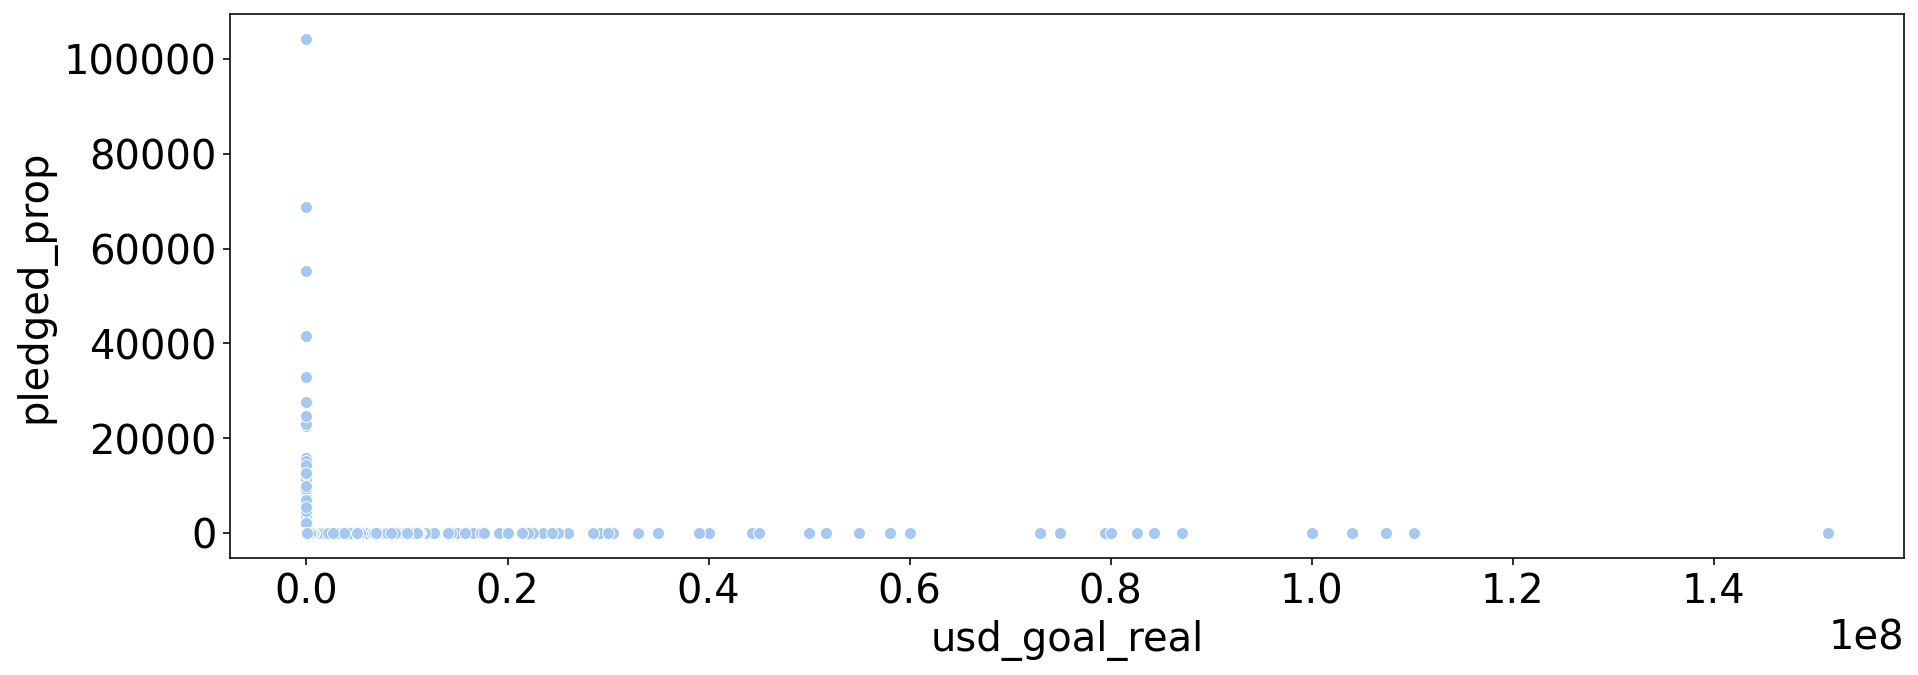

In [72]:
# check relationship between usd_goal_real and prop_pledged visually
sns.scatterplot(x = 'usd_goal_real', y = 'pledged_prop', data = ks_state)

Pledged proportion is higher for significantly low values of goal. For higher values of goal, the pledged amount is equal to zero.

We used logarithmic scaling on our 'usd_goal_real' variable before conducting linear regression 

In [73]:
# add log transformation 
ks_state['log_goal'] = np.log10(ks_state['usd_goal_real'])

In [74]:
ks_state.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,duration,pledged_prop,log_goal
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,1533.95,59,0.000000,3.185811
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2421.0,30000.00,60,0.080700,4.477121
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,45000.00,45,0.004889,4.653213
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,5000.00,30,0.000200,3.698970
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,50000.00,35,1.047500,4.698970


<AxesSubplot:xlabel='log_goal', ylabel='pledged_prop'>

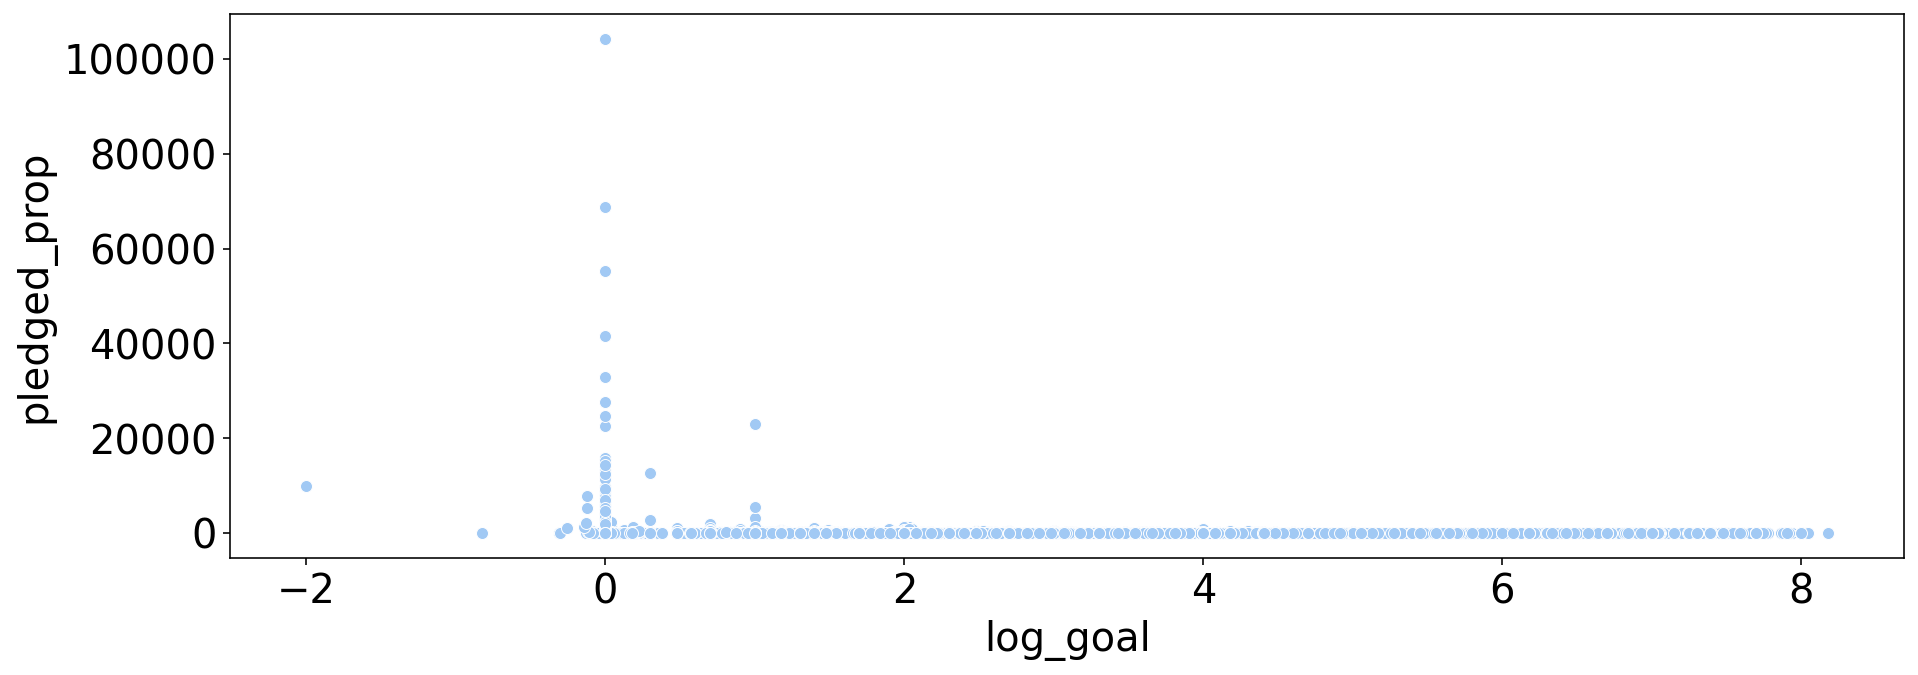

In [75]:
sns.scatterplot(x = 'log_goal', y = 'pledged_prop', data = ks_state)

In [76]:
# regression using log-transformed goal
outcome, predictors = patsy.dmatrices('pledged_prop ~ log_goal', ks_state)
model = sm.OLS(outcome,predictors)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           pledged_prop   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     717.8
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          6.08e-158
Time:                        22:25:44   Log-Likelihood:            -2.3408e+06
No. Observations:              331461   AIC:                         4.682e+06
Df Residuals:                  331459   BIC:                         4.682e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.8727      2.562     27.667      0.0

Since there is a log transformation applied, we divide the coefficient of log_goal by 100 to interpret the results. 

$$ Proportion Pledged = 70.8727 - 18.0753  * log_{10}(Goal) $$

For every 1 unit increase in Goal, there is a 0.180753 unit decrease in Proportion Pledged.

- The p-value here is <0.05 which shows us that there is a significant effect of the predictor variable (goal) on the proportion of money pledged on average however, the size of this effect is not very large. 
- This does agree with our hypothesis that lower goals have a higher success rate (proportion pledged)
- But we would like to keep in mind that our R-squared value is 0.002, which implies that only 0.2% of the outcome variability is explained by the predictor.

Text(0.5, 1.0, 'Linear regression using Log Transformation of usd_goal_real')

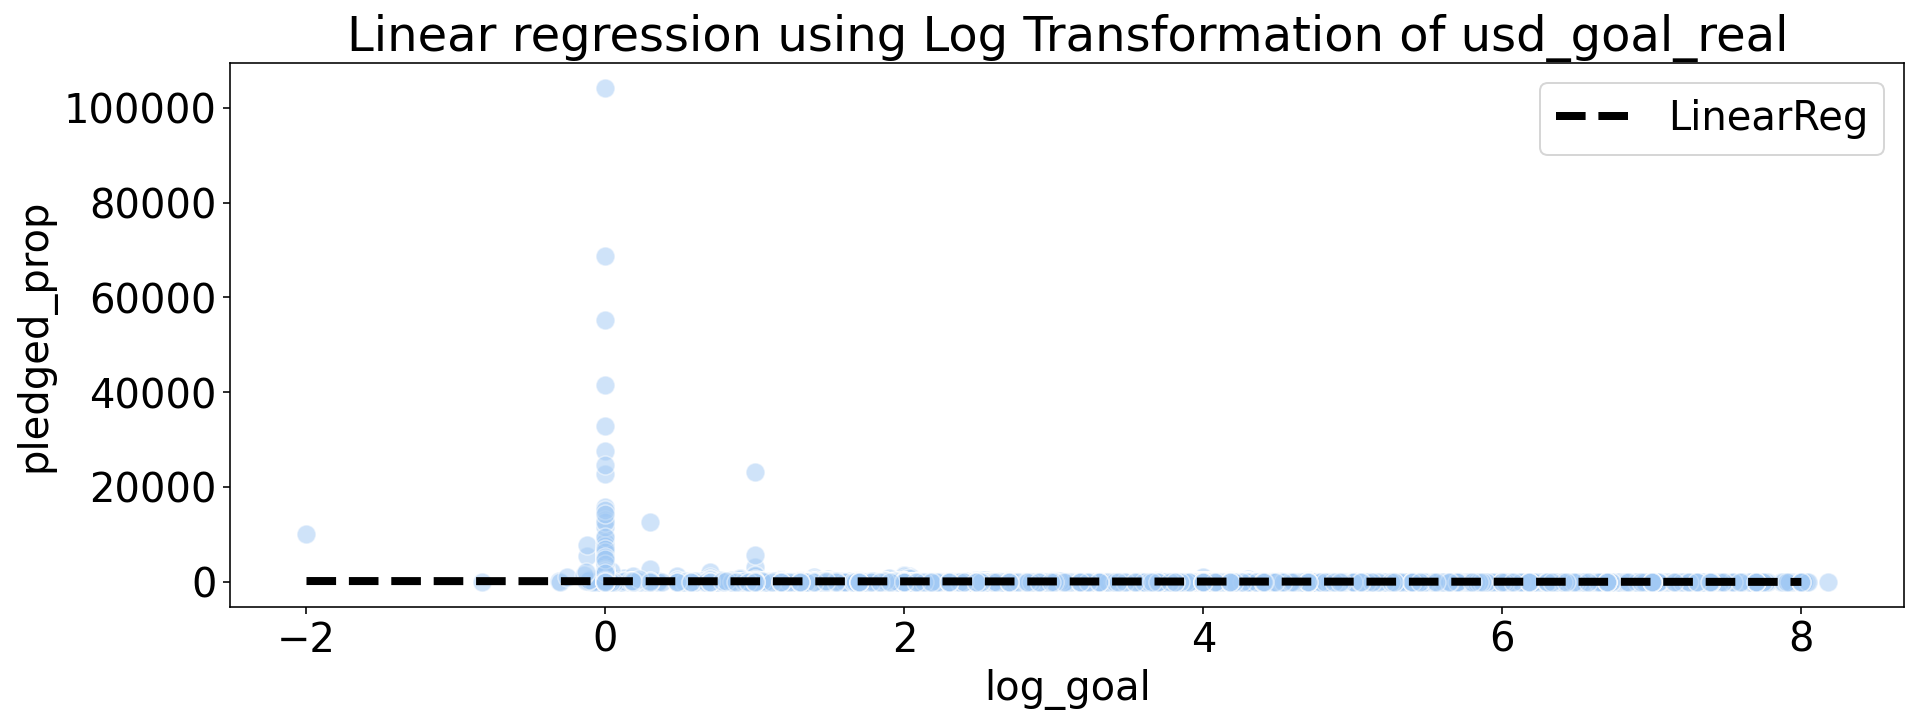

In [90]:
# plot model 
sns.scatterplot(x = 'log_goal', y = 'pledged_prop', data = ks_state, alpha = 0.5, s = 90)
xs = np.arange(ks_state['log_goal'].min(), ks_state['log_goal'].max())
line = -18.0753 * xs + 70.8727
plt.plot(xs, line, '--k', label = 'LinearReg', linewidth = 4)
plt.legend()
plt.title('Linear regression using Log Transformation of usd_goal_real')

### main_category wise linear regression against proportion pledged

In [78]:
#only main_category model
outcome, predictors = patsy.dmatrices('pledged_prop ~ main_category', ks_state)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           pledged_prop   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.592
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           0.000947
Time:                        22:26:31   Log-Likelihood:            -2.3411e+06
No. Observations:              331461   AIC:                         4.682e+06
Df Residuals:                  331446   BIC:                         4.682e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* As observed in the combined model, the Games and Music category once again seem to have significant p-values of 0.022 and 0.005 respectively. However, the R-squared value continues to be 0.

### Country wise linear regression against proportion pledged

Analysing whether there is a significant difference between mean proportion pledged values per country

<AxesSubplot:xlabel='country', ylabel='pledged_prop'>

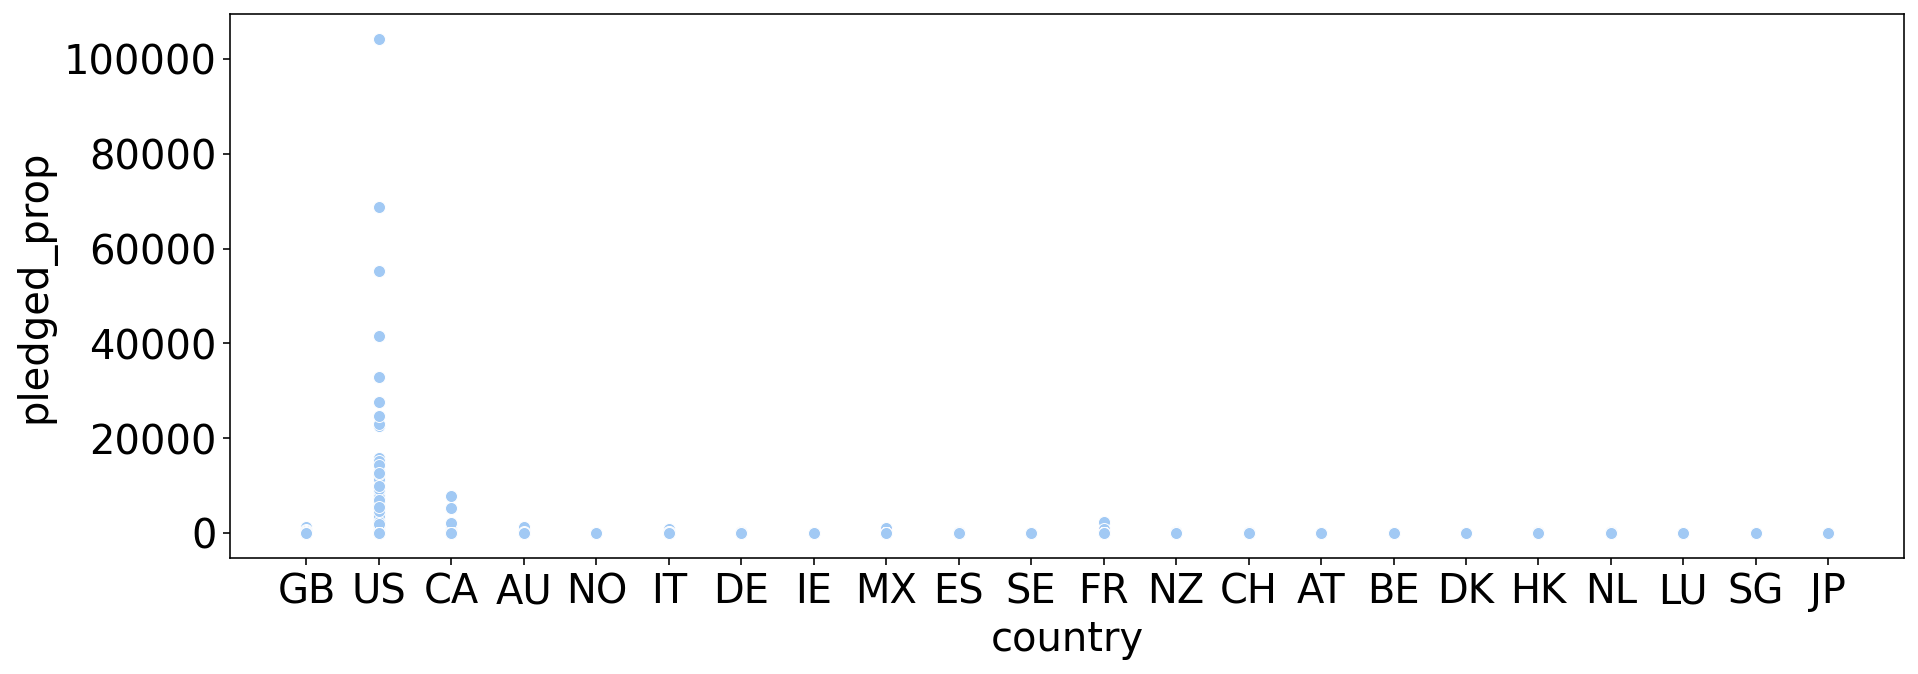

In [79]:
sns.scatterplot(x = 'country', y = 'pledged_prop', data = ks_state)

In [80]:
# create dummy variables for countries
encoded_country = pd.get_dummies(ks_state, columns = ['country'], drop_first = True)
X = encoded_country.drop(['name', 'main_category', 'pledged_prop', 'category', 'currency', 'deadline', 'goal', 'launched',
            'pledged', 'state', 'backers', 'usd_pledged_real', 'usd_goal_real',
            'duration', 'log_goal', 'ID'], axis = 1)
X.head()

,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
y = encoded_country['pledged_prop']
y.head()

0    0.000000
1    0.080700
2    0.004889
3    0.000200
5    1.047500
Name: pledged_prop, dtype: float64

Linear Regression

In [82]:
regr = LinearRegression()
model = regr.fit(X, y)

In [83]:
r_squared = regr.score(X,y)
print("R Squared score: ", r_squared)

R Squared score:  1.578843134075747e-05


The Linear Regression shows us that the R squared value is very low. This shows us that the percentage of variation in Proportion pledged explained by country is almost = 0. Country is not a strong predictor overall of the success rate (proportion pledged).

In [84]:
coeff = pd.DataFrame(regr.coef_,X.columns,columns=['Coefficient'])
coeff

,Coefficient
country_AU,0.615228
country_BE,0.015911
country_CA,1.731213
country_CH,0.332940
country_DE,0.373436
country_DK,0.231273
country_ES,0.320783
country_FR,1.707258
country_GB,0.544078
country_HK,1.458390


These coefficient values are the differences in mean proportion pledged between each country and 'country_AT' (Austria).

In [85]:
outcome, predictors = patsy.dmatrices('pledged_prop ~ country', ks_state)
model = sm.OLS(outcome,predictors)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           pledged_prop   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2492
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               1.00
Time:                        22:26:45   Log-Likelihood:            -2.3411e+06
No. Observations:              331461   AIC:                         4.682e+06
Df Residuals:                  331439   BIC:                         4.683e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6355     12.834      0.050

The p values for each country is >0.05 which means there is no significant difference between mean proportion pledged between each of these countries and country_AT.

We decided to additionally conduct an ANOVA to determine whether there is a significant difference between the mean proportion pledged between each country.
- __Null Hypothesis__: There is no significant difference between mean proportion pledged per country
- __Alternate Hypothesis__: There is a significant difference between mean proportion pledged per country

In [86]:
mod = ols('pledged_prop ~ country', ks_state).fit()
anova = sm.stats.anova_lm(mod, typ = 2)
print(anova)

                sum_sq        df        F    PR(>F)
country   4.180176e+05      21.0  0.24919  0.999808
Residual  2.647578e+10  331439.0      NaN       NaN


Our F statistic = 0.249182 and our P value = 0.999808. We retain the null hypothesis that there is no significant difference between the mean proportion pledged per country.

In [87]:
coeff = coeff.reset_index()
coeff = coeff.rename(columns = {'index': 'countries'})

In [88]:
coeff

,countries,Coefficient
0,country_AU,0.615228
1,country_BE,0.015911
2,country_CA,1.731213
3,country_CH,0.332940
4,country_DE,0.373436
5,country_DK,0.231273
6,country_ES,0.320783
7,country_FR,1.707258
8,country_GB,0.544078
9,country_HK,1.458390


Text(0, 0.5, 'Coefficients from linear regression')

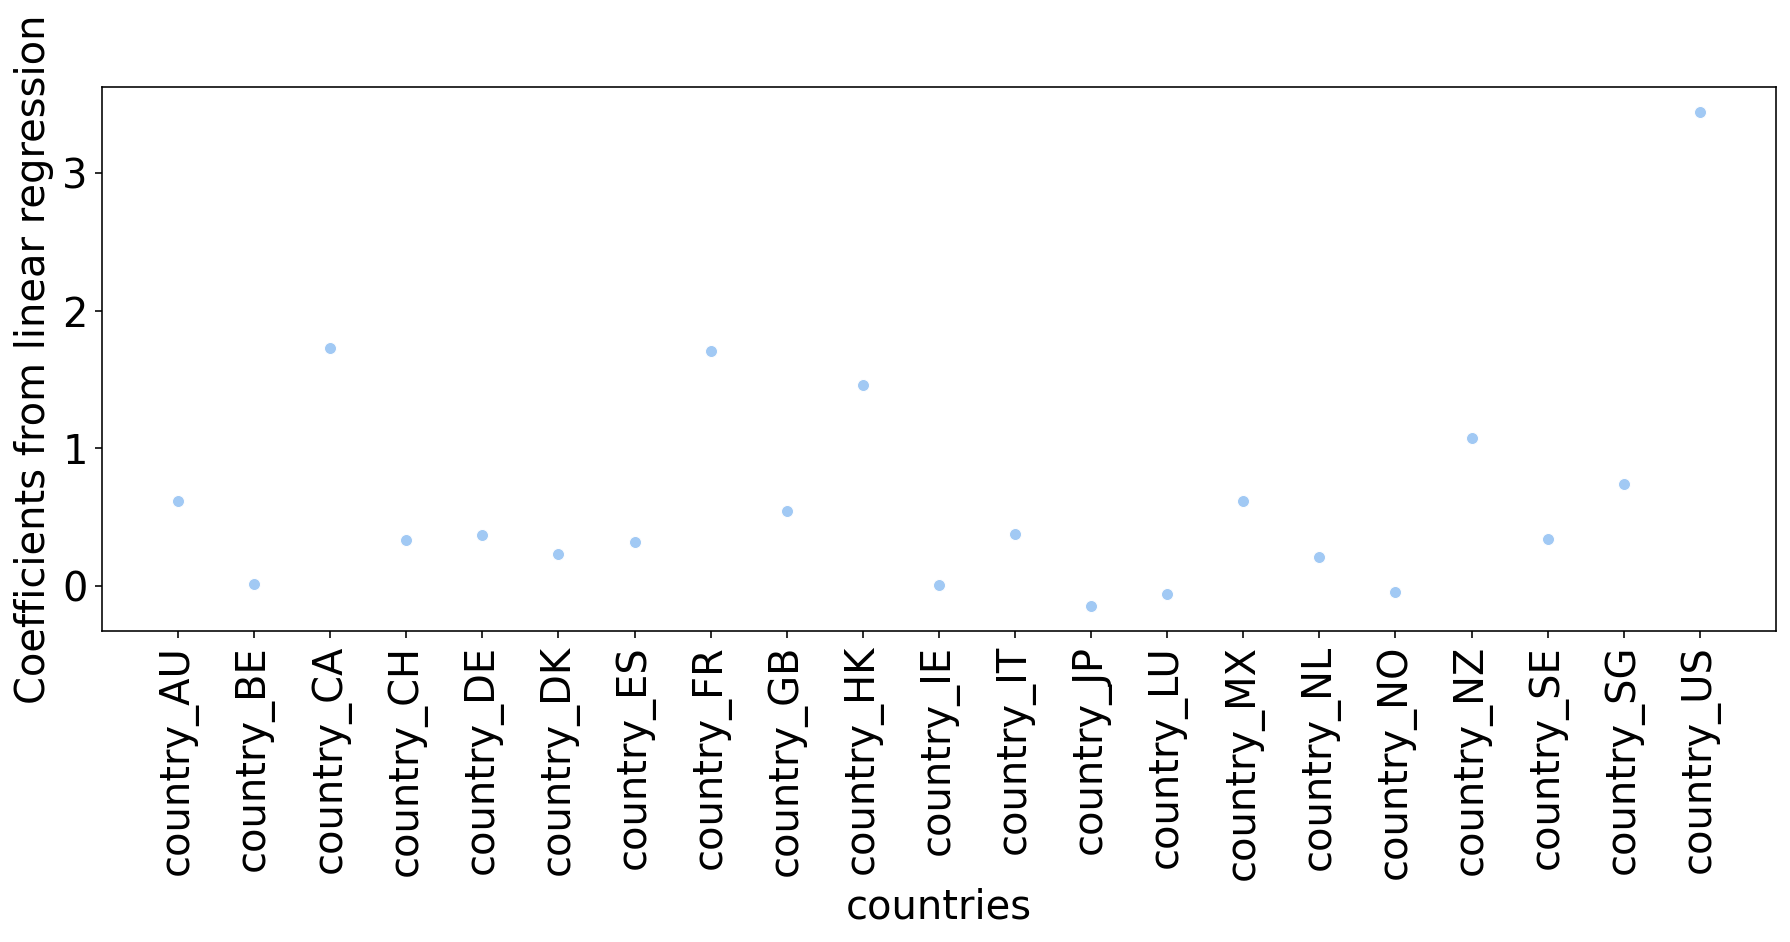

In [89]:
sns.scatterplot(x = 'countries', y = 'Coefficient', data = coeff)
plt.xticks(rotation = 90)
plt.ylabel('Coefficients from linear regression')

Our results disagree with our hypothesis that campaigns from western countries have a higher success rate. There is no significant relationship between country and success rate (proportion pledged).

# Ethics & Privacy

The dataset we are using in this project is the “Kickstarter Projects” dataset from Kaggle. We have permission to use and analyze these datasets since Kaggle allows the public to explore, publish, and access them, Furthermore, within the dataset, there is no data containing personal information such as name, age, ethnicity, or education that could be used for malicious purposes. According to the Kickstarter’s policy on “Trust & Safety” (https://www.kickstarter.com/trust), details about the project and information, including project name and locations, are publicly provided for the backers to explore different projects. Thus, we don’t see any privacy concern as all this information is already publicly available on Kickstarter and does not access confidential data.
 
There are no biases in the way the data was collected as this was simply done through web scraping of the Kickstarter platform. However, a large proportion of the campaigns were from the US due to its higher popularity there, and this could lead to unbalanced classes in the analysis. To handle this, we used a success rate measure (proportion pledged) instead of the count of successes.
Our analysis focused on completed rather than ‘live’ campaigns as this analysis could influence potential investors’ decisions and affect the success of ongoing campaigns. 



# Conclusion & Discussion

#### Results and Summary 
We conducted data analysis to determine the relationship between funding goal, main category, and location of a Kickstarter campaign and its success. We wanted to determine what factors of a campaign relate to a higher chance of its success. We used linear regression models to determine the strength and direction of the relationships and further conducted a T-test and ANOVA to determine whether there was a significant difference in average success rate within our variables. Additionally, we implemented chi-squared tests and logistic regression using a binary variable (success vs failed) as our outcome. 
 
Our results show that there is a significant difference between goal amounts of successful and failed campaigns. We found that campaigns with lower goals had a much higher success rate and campaigns with high goal amounts had a success rate approximately equal to zero. 
 
Although our chi-squared test did show us significant p-values for our analysis of main category and location in relation to success, this is due to a large sample size where even a minute difference would lead to the detection of association. After conducting linear and logistic regression, we found that the R-squared values were low, indicating that a very small percentage of the success of a campaign is explained by the main category and location. Therefore, both the main category and location do not act as  significant predictors of success.
 
We predicted that campaigns in western countries would have higher success rates but we found that it was Hong Kong that had the highest proportion of success. We also hypothesized that campaigns in the category of Technology would have higher success rates but we found that Technology had the highest proportion of failed campaigns overall.
 
 
#### Limitations
Kickstarter is a platform more popular in western countries (particularly the US). In order to conduct a more globally applicable analysis, we would need equal amounts of data from a larger variety of countries.
We could additionally conduct a text analysis to determine whether certain names or descriptions of projects have a higher likelihood of success.
Our analysis also only focused on successful and failed projects, we could further analyse the states ‘suspended’, ‘live’, and ‘canceled’.
 
 
#### Impact on Society 
Kickstarter is a popular platform used by startups to gain funding for their projects. Our analysis could be used by future startups/projects in order to create a successful campaign. 


# Team Contributions

- __Seokhyun:__ Data Cleaning, EDA, Chi-Squared Tests
- __Jieun:__ Data Cleaning, EDA, Logistic Regression
- __Gauri:__ Data Cleaning, EDA, T-test and Linear regression, Heatmaps
- __Aditi:__ Data Clearning, EDA, Linear regression with ANOVA and Log transformation

